In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.model_selection import learning_curve 
from sklearn.metrics import make_scorer 
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import xgboost
import eli5
from eli5.sklearn import PermutationImportance
import shap
import random
import numpy

C:\Users\mulya\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\mulya\AppData\Local\Programs\Python\Python310\lib\site-packages\pkg_resources\__init__.py:122: PkgResourcesDeprecationWarning: tplotlib is an invalid version and will not be supported in a future release
  warnings.warn(


**Читаем базу данных:**

In [81]:
df=pd.read_csv('.\new_base.csv', sep = ',')

**Функция отрисовки матрицы ошибок:**

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range(0,cm.shape[0]):
        for j in range(0,cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинный результат')
    plt.xlabel('Предсказанный результат')

font = {'size' : 15}
plt.rc('font', **font)

**Соберем данные для обучения моделей и разобьем на train и test:**

In [82]:
all_data=df.drop(labels=['target'],axis=1).fillna(0)
all_result=df['target'].fillna(0)
train_data,test_data, train_result, test_result = train_test_split(all_data,all_result, stratify=df['target'], random_state=23)

**Логистическая регрессия:**

In [7]:
log_regr=LogisticRegression().fit(train_data,train_result)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Confusion matrix, without normalization
[[407  61]
 [ 95 159]]


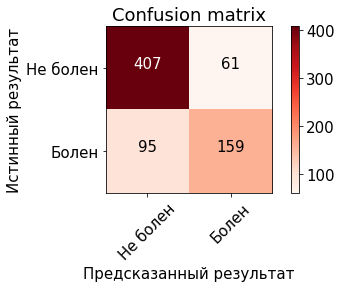

Precision = 0.7227272727272728
Recall = 0.6259842519685039
F1 = 0.6708860759493671
ROC-AUC = 0.7478211858133118


In [8]:
cnf_matrix = confusion_matrix(test_result, log_regr.predict(test_data))
plot_confusion_matrix(cnf_matrix, classes=['Не болен', 'Болен'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_log_regr.png")
plt.show()
print("Precision = {}".format(precision_score(test_result, log_regr.predict(test_data))))
print("Recall = {}".format(recall_score(test_result, log_regr.predict(test_data))))
print("F1 = {}".format(f1_score(test_result, log_regr.predict(test_data))))
print("ROC-AUC = {}".format(roc_auc_score(test_result, log_regr.predict(test_data))))

**Обучим модель 10 раз с различными сидами и усредним метрики:**

In [9]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
#Обучаем 10 раз и записываем метрики каждого раза
log_regr_precision = []
log_regr_recall = []
log_regr_f1 = []
log_regr_roc_auc = []
all_data=df.drop(labels=['target'],axis=1).fillna(0)
all_result=df['target'].fillna(0)
for i in range(0,10):    
    train_data_log_regr,test_data_log_regr, train_result_log_regr, test_result_log_regr = train_test_split(all_data,all_result, stratify=df['target'], random_state=int(seeds[i]))
    log_regr=LogisticRegression().fit(train_data_log_regr,train_result_log_regr)
    log_regr_precision.append(precision_score(test_result_log_regr, log_regr.predict(test_data_log_regr)))
    log_regr_recall.append(recall_score(test_result_log_regr, log_regr.predict(test_data_log_regr)))
    log_regr_f1.append(f1_score(test_result_log_regr, log_regr.predict(test_data_log_regr)))
    log_regr_roc_auc.append(roc_auc_score(test_result_log_regr, log_regr.predict(test_data_log_regr)))

#Складываем все метрики
precision_sum = 0
recall_sum = 0
f1_sum = 0
roc_auc_sum = 0
for i in range(0,10):
    precision_sum += log_regr_precision[i]
    recall_sum += log_regr_recall[i]
    f1_sum += log_regr_f1[i]
    roc_auc_sum += log_regr_roc_auc[i]

#Находим среднее
precision_average = precision_sum/10
recall_average = recall_sum/10
f1_average = f1_sum/10
roc_auc_average = roc_auc_sum/10

#Находим сумму квадратов разности между средним и каждым i-тым результатом
precision_sqr_sum = 0
recall_sqr_sum = 0
f1_sqr_sum = 0
roc_auc_sum = 0
for i in range(0,10):
    precision_sqr_sum += (precision_average - log_regr_precision[i])**2
    recall_sqr_sum += (recall_average - log_regr_recall[i])**2
    f1_sqr_sum += (f1_average - log_regr_f1[i])**2
    roc_auc_sum += (roc_auc_average - log_regr_roc_auc[i])**2

#Находим погрешность каждой метрики
precision_average_pogr = (precision_sqr_sum/10)**0.5
recall_average_pogr = (recall_sqr_sum/10)**0.5
f1_average_pogr = (f1_sqr_sum/10)**0.5
roc_auc_average_pogr = (roc_auc_sum/10)**0.5

#Выводим результат
print('Precision = {}'.format(precision_average) + ' +- {}'.format(precision_average_pogr))
print('Recall = {}'.format(recall_average) + ' +- {}'.format(recall_average_pogr))
print('F1 = {}'.format(f1_average) + ' +- {}'.format(f1_average_pogr))
print('ROC-AUC = {}'.format(roc_auc_average) + ' +- {}'.format(roc_auc_average_pogr))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Precision = 0.6902876917220768 +- 0.029124505023322388
Recall = 0.6287401574803149 +- 0.02199445310781641
F1 = 0.6575452208258498 +- 0.01711864518150557
ROC-AUC = 0.737340164210243 +- 0.012927941094560127


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


**Permutation Importance для логистической регрессии:**

In [10]:
perm=PermutationImportance(log_regr,random_state=1).fit(test_data,test_result)
table=eli5.show_weights(perm,feature_names=df.drop(labels=['target'],axis=1).columns.tolist(),top=30)
result1 = pd.read_html(table.data)[0]
table

**Проверим на устойчивость:**

In [11]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
names=df.drop(labels=['target'],axis=1).columns.tolist()
sustain_counter_log_regr_pi = dict.fromkeys(names)
for i in range(0,len(names)):
    sustain_counter_log_regr_pi[names[i]] = []

for i in range(0,10):
    train_data_log_regr_pi,test_data_log_regr_pi,train_result_log_regr_pi,test_result_log_regr_pi = train_test_split(all_data, all_result, test_size=0.3, random_state=int(seeds[i]))
    log_regr = LogisticRegression().fit(train_data_log_regr_pi, train_result_log_regr_pi)
    perm = PermutationImportance(log_regr).fit(test_data_log_regr_pi,test_result_log_regr_pi)
    table_log_regr_pi = eli5.show_weights(perm, feature_names=names, top=85)
    result_log_regr_pi = pd.read_html(table_log_regr_pi.data)[0]
    for i in range(0,len(names)):
        sustain_counter_log_regr_pi[result_log_regr_pi['Feature'][i]].append(i)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

**Посчитаем среднее место каждого нутриента в списке и стандартное отклонение от этого значения:**

In [12]:
sum_log_regr_pi = {}
pogr_log_regr_pi = {}
for i in range(0,len(names)):
        sum_log_regr_pi[names[i]] = np.mean(sustain_counter_log_regr_pi[names[i]])
        pogr_log_regr_pi[names[i]] = np.std(sustain_counter_log_regr_pi[names[i]])
for i in range(0,len(names)):
    print(names[i],': ',sum_log_regr_pi[names[i]],' ',pogr_log_regr_pi[names[i]])

возраст :  75.6   13.544002362669612
пол :  45.1   8.802840450672726
масса_тела :  0.0   0.0
рост :  3.5   0.5
от :  10.4   2.4166091947189146
об :  50.7   22.050170067371365
оп :  28.8   17.792133093027378
жм :  8.0   2.5298221281347035
мм :  47.6   27.203676222157917
ож :  14.4   3.0397368307141326
внутриклеточная_жидкость :  43.2   16.141871019184855
тощая_мт :  11.1   2.8792360097775935
акм :  48.2   19.21874085365636
холестерин :  60.3   17.02967997350508
нас._жир :  47.8   23.72256309929431
натрий_na :  42.0   23.954122818421048
сахара :  49.3   32.517841256762416
энергия :  22.9   27.35854528296415
вода :  75.3   17.624131184259834
пищ._волокна :  47.5   21.07249391979981
мононенас._жир :  45.7   17.89441253576099
белки :  32.5   21.625216761919404
аргинин :  45.9   15.313066316058322
валин :  46.2   15.058552387264852
зола :  49.6   14.178857499812882
полиненас._жир :  44.9   17.24209964012504
калий_k :  31.5   31.938221616113818
крахмал :  41.0   28.44644090215857
гистидин :  

**SHAP для логистической регрессии:**

**Случайный лес:**

In [8]:
rand_forest=RandomForestClassifier().fit(train_data,train_result)

Confusion matrix, without normalization
[[399  69]
 [ 79 175]]


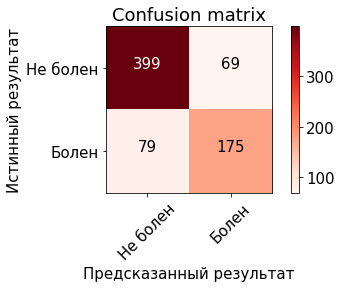

Precision = 0.7172131147540983
Recall = 0.6889763779527559
ROC-AUC = 0.7707702402584293
F1 = 0.7028112449799195


In [9]:
cnf_matrix = confusion_matrix(test_result, rand_forest.predict(test_data))
plot_confusion_matrix(cnf_matrix, classes=['Не болен', 'Болен'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_random_forest.png")
plt.show()
print("Precision = {}".format(precision_score(test_result, rand_forest.predict(test_data))))
print("Recall = {}".format(recall_score(test_result, rand_forest.predict(test_data))))
print("ROC-AUC = {}".format(roc_auc_score(test_result, rand_forest.predict(test_data))))
print("F1 = {}".format(f1_score(test_result,rand_forest.predict(test_data))))

**Обучим модель 10 раз с различными сидами и усредним метрики:**

In [15]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
#Обучаем 10 раз и записываем метрики каждого раза
rand_forest_precision = []
rand_forest_recall = []
rand_forest_f1 = []
rand_forest_roc_auc = []
all_data=df.drop(labels=['target'],axis=1).fillna(0)
all_result=df['target'].fillna(0)
for i in range(0,10):    
    train_data_rand_forest,test_data_rand_forest, train_result_rand_forest, test_result_rand_forest = train_test_split(all_data,all_result, stratify=df['target'], random_state=int(seeds[i]))
    rand_forest = RandomForestClassifier().fit(train_data_rand_forest,train_result_rand_forest)
    rand_forest_precision.append(precision_score(test_result_rand_forest, rand_forest.predict(test_data_rand_forest)))
    rand_forest_recall.append(recall_score(test_result_rand_forest, rand_forest.predict(test_data_rand_forest)))
    rand_forest_f1.append(f1_score(test_result_rand_forest, rand_forest.predict(test_data_rand_forest)))
    rand_forest_roc_auc.append(roc_auc_score(test_result_rand_forest, rand_forest.predict(test_data_rand_forest)))

#Складываем все метрики
precision_sum = 0
recall_sum = 0
f1_sum = 0
roc_auc_sum = 0
for i in range(0,10):
    precision_sum += rand_forest_precision[i]
    recall_sum += rand_forest_recall[i]
    f1_sum += rand_forest_f1[i]
    roc_auc_sum += rand_forest_roc_auc[i]

#Находим среднее
precision_average = precision_sum/10
recall_average = recall_sum/10
f1_average = f1_sum/10
roc_auc_average = roc_auc_sum/10

#Находим сумму квадратов разности между средним и каждым i-тым результатом
precision_sqr_sum = 0
recall_sqr_sum = 0
f1_sqr_sum = 0
roc_auc_sum = 0
for i in range(0,10):
    precision_sqr_sum += (precision_average - rand_forest_precision[i])**2
    recall_sqr_sum += (recall_average - rand_forest_recall[i])**2
    f1_sqr_sum += (f1_average - rand_forest_f1[i])**2
    roc_auc_sum += (roc_auc_average - rand_forest_roc_auc[i])**2

#Находим погрешность каждой метрики
precision_average_pogr = (precision_sqr_sum/10)**0.5
recall_average_pogr = (recall_sqr_sum/10)**0.5
f1_average_pogr = (f1_sqr_sum/10)**0.5
roc_auc_average_pogr = (roc_auc_sum/10)**0.5

#Выводим результат
print('Precision = {}'.format(precision_average) + ' +- {}'.format(precision_average_pogr))
print('Recall = {}'.format(recall_average) + ' +- {}'.format(recall_average_pogr))
print('F1 = {}'.format(f1_average) + ' +- {}'.format(f1_average_pogr))
print('ROC-AUC = {}'.format(roc_auc_average) + ' +- {}'.format(roc_auc_average_pogr))

Precision = 0.7196930202162902 +- 0.024109165869788195
Recall = 0.729527559055118 +- 0.022344037202618447
F1 = 0.7240163529049326 +- 0.011968740323980933
ROC-AUC = 0.7871996769634565 +- 0.00933838818637093


**Permutation Importance для случайного леса:**

In [16]:
perm = PermutationImportance(rand_forest,random_state=1).fit(test_data,test_result)
table = eli5.show_weights(perm,feature_names=df.drop(labels=['target'],axis=1).columns.tolist(),top=30)
result2 = pd.read_html(table.data)[0]
table

**Проверим на устойчивость:**

In [17]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
names=df.drop(labels=['target'],axis=1).columns.tolist()
sustain_counter_rand_forest_pi=dict.fromkeys(names)
for i in range(0,len(names)):
    sustain_counter_rand_forest_pi[names[i]]=[]

for i in range(0,10):
    train_data_rand_forest_pi,test_data_rand_forest_pi,train_result_rand_forest_pi,test_result_rand_forest_pi=train_test_split(all_data, all_result, test_size=0.3, random_state=int(seeds[i]))
    random_forest = RandomForestClassifier().fit(train_data_rand_forest_pi,train_result_rand_forest_pi)
    perm = PermutationImportance(random_forest).fit(test_data_rand_forest_pi,test_result_rand_forest_pi)
    table_rand_forest_pi = eli5.show_weights(perm, feature_names=names, top=85)
    result_rand_forest_pi = pd.read_html(table_rand_forest_pi.data)[0]
    for i in range(0,len(names)):
        sustain_counter_rand_forest_pi[result_rand_forest_pi['Feature'][i]].append(i)

**Посчитаем среднее место каждого нутриента в списке и стандартное отклонение от этого значения:**

In [18]:
sum_rand_forest_pi = {}
pogr_rand_forest_pi = {}
for i in range(0,len(names)):
        sum_rand_forest_pi[names[i]] = np.mean(sustain_counter_rand_forest_pi[names[i]])
        pogr_rand_forest_pi[names[i]] = np.std(sustain_counter_rand_forest_pi[names[i]])
for i in range(0,len(names)):
    print(names[i],': ',sum_rand_forest_pi[names[i]],' ',pogr_rand_forest_pi[names[i]])

возраст :  0.1   0.30000000000000004
пол :  53.6   17.516849031718003
масса_тела :  8.6   13.10877568653915
рост :  12.9   16.759773268156106
от :  37.7   19.784084512557055
об :  56.7   26.705991837039118
оп :  28.9   19.028662590944222
жм :  49.2   33.31306050185122
мм :  50.8   25.78294009611782
ож :  53.5   26.139051245215462
внутриклеточная_жидкость :  37.2   19.84338680769994
тощая_мт :  62.8   22.73235579520961
акм :  49.0   15.21840990379744
холестерин :  35.8   26.70131082924582
нас._жир :  52.0   23.01303978182804
натрий_na :  35.0   21.358838919754042
сахара :  39.9   18.074567767999323
энергия :  41.8   16.61204382368407
вода :  54.8   22.121482771279144
пищ._волокна :  41.4   23.38888624966995
мононенас._жир :  43.8   22.93817778290159
белки :  46.8   19.124852940611074
аргинин :  45.1   26.44787326043438
валин :  51.7   23.87069332884992
зола :  45.0   21.78072542409917
полиненас._жир :  38.5   26.17345984007464
калий_k :  57.4   23.83778513201258
крахмал :  36.9   26.703

**SHAP для случайного леса:**

In [10]:
explainer = shap.explainers.Tree(rand_forest)
shap_values1 = explainer(df.drop(labels=['target'],axis=1))

In [11]:
shap_values111=[ []*85 for i in range(2163) ]
for i in range (0,2163):
    for j in range(0,85):
        shap_values111[i].append(shap_values1.values[i][j][0])

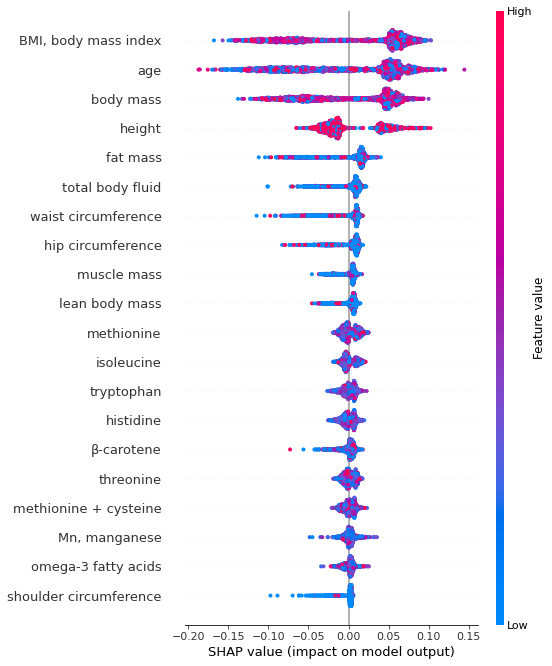

In [12]:
shap.summary_plot(numpy.asarray(shap_values111), features=train_data, feature_names=train_data.columns.tolist(), max_display=None, plot_type=None, 
                  color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, 
                  plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None)
spisok2 = train_data.columns[np.argsort(np.abs(shap_values111).mean(0))].tolist()
spisok2.reverse()

**Проверим на устойчивость SHAP:**

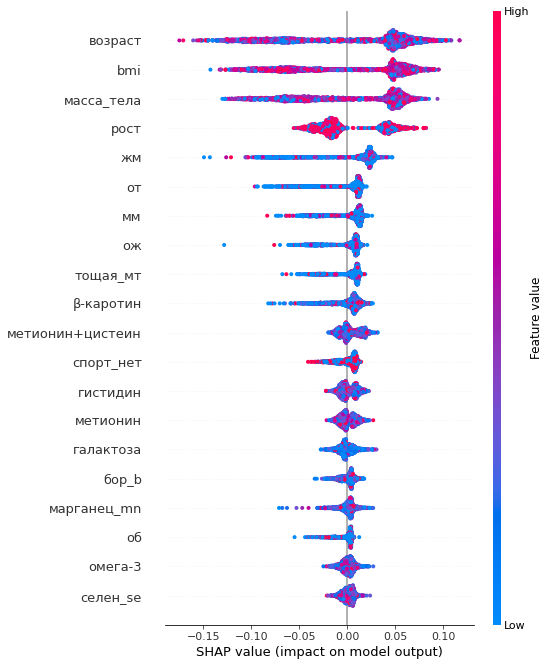

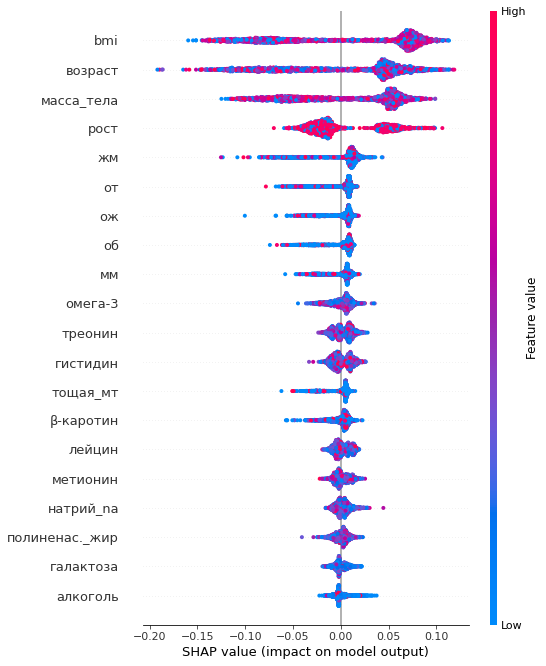

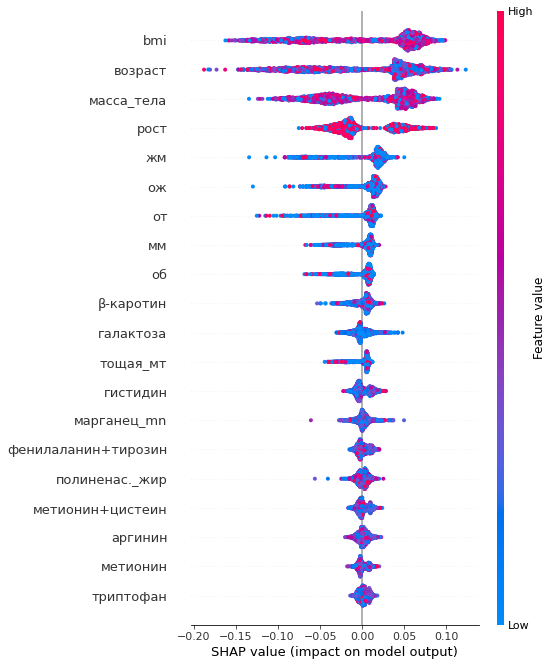

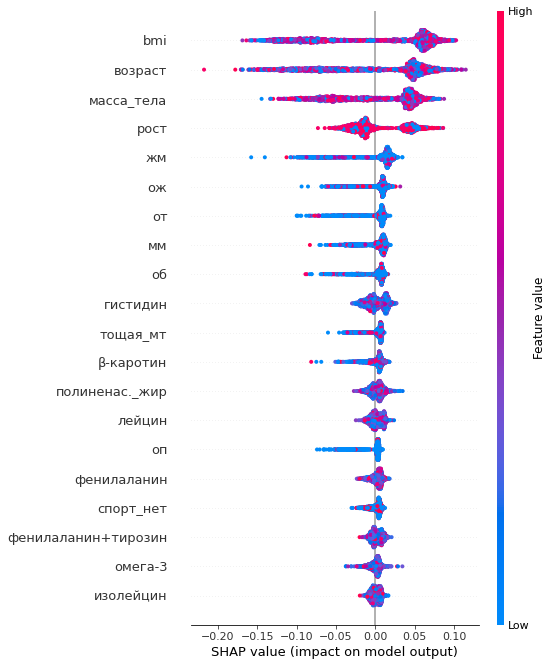

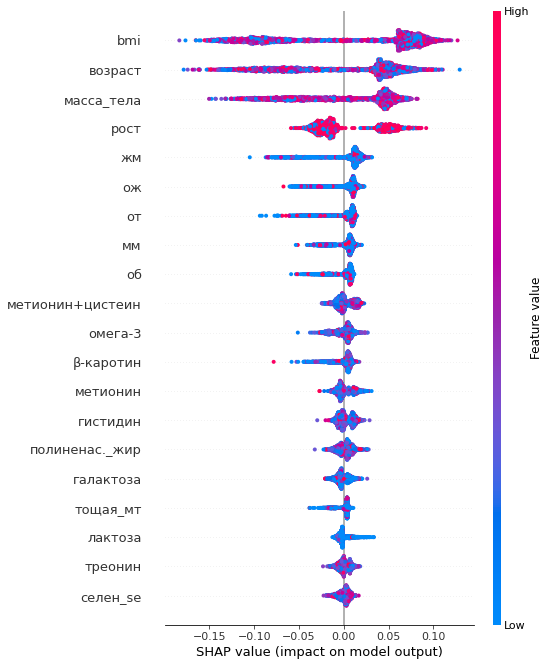

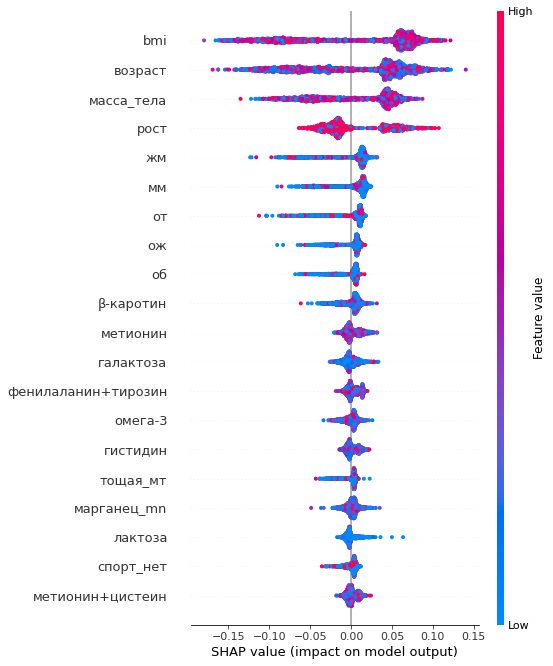

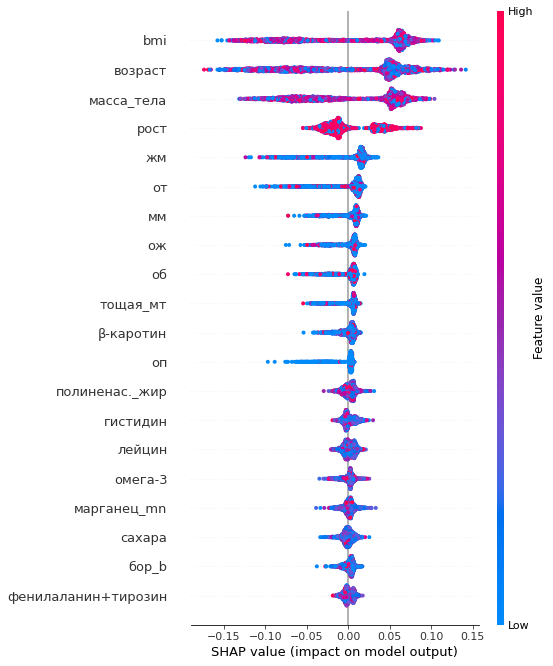

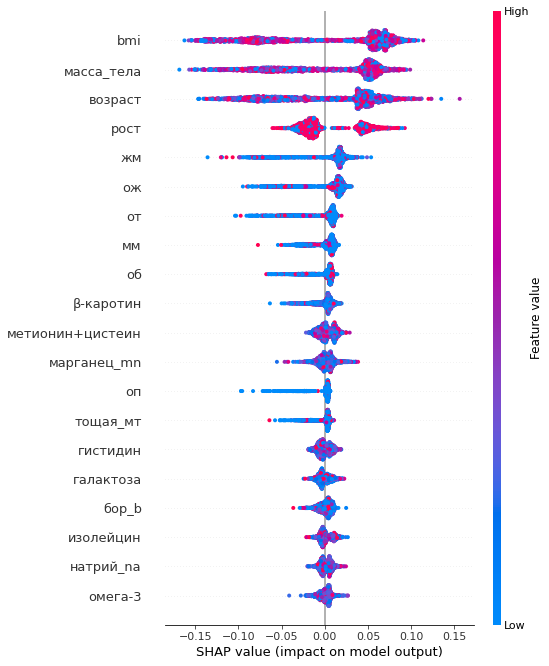

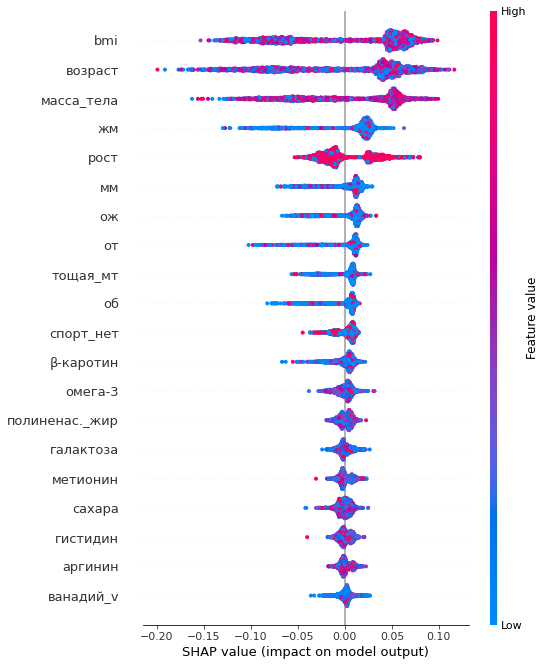

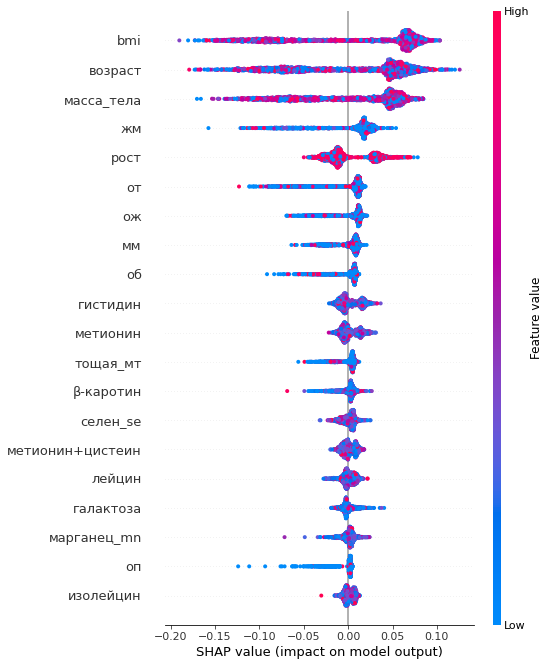

In [22]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
names = df.drop(labels=['target'],axis=1).columns.tolist()
sustain_counter_rand_forest_shap = dict.fromkeys(names)
for i in range(0,len(names)):
    sustain_counter_rand_forest_shap[names[i]]=[]
for i in range(0,10):
    train_data_rand_forest_shap, test_data_rand_forest_shap, train_result_rand_forest_shap, test_result_rand_forest_shap = train_test_split(all_data, all_result, test_size=0.3, random_state=int(seeds[i]))
    random_forest = RandomForestClassifier().fit(train_data_rand_forest_shap, train_result_rand_forest_shap)
    explainer = shap.explainers.Tree(random_forest)
    shap_values1 = explainer(df.drop(labels=['target'],axis=1))
    shap_values111=[ []*85 for i in range(2163) ]
    for i in range (0,2163):
        for j in range(0,85):
            shap_values111[i].append(shap_values1.values[i][j][0])
    table = shap.summary_plot(numpy.asarray(shap_values111), features=train_data, feature_names=train_data.columns.tolist(), max_display=None, plot_type=None, 
                      color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, 
                      plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None)
    sustain_counter_i = train_data.columns[np.argsort(np.abs(shap_values111).mean(0))].tolist()
    for counter in range(0, len(names)):
        sustain_counter_rand_forest_shap[sustain_counter_i[counter]].append(84-counter)

**Посчитаем среднее место каждого нутриента в списке и стандартное отклонение от этого значения:**

In [23]:
sum_rand_forest_shap = {}
pogr_rand_forest_shap = {}
for i in range(0,len(names)):
        sum_rand_forest_shap[names[i]] = np.mean(sustain_counter_rand_forest_shap[names[i]])
        pogr_rand_forest_shap[names[i]] = np.std(sustain_counter_rand_forest_shap[names[i]])
for i in range(0,len(names)):
    print(names[i],': ',sum_rand_forest_shap[names[i]],' ',pogr_rand_forest_shap[names[i]])

возраст :  1.0   0.4472135954999579
пол :  81.8   2.4413111231467406
масса_тела :  1.9   0.3
рост :  3.2   0.39999999999999997
от :  5.7   0.6403124237432849
об :  8.9   2.736786436680802
оп :  23.2   9.064215354899728
жм :  3.8   0.39999999999999997
мм :  6.5   0.9219544457292888
ож :  5.9   0.8306623862918076
внутриклеточная_жидкость :  80.5   1.5652475842498528
тощая_мт :  11.3   2.6095976701399777
акм :  79.0   1.7888543819998317
холестерин :  37.7   14.852945835759316
нас._жир :  63.6   10.489995233554684
натрий_na :  35.4   14.221111067704943
сахара :  30.6   9.8812954616285
энергия :  58.0   11.072488428533127
вода :  36.9   7.449161026585477
пищ._волокна :  66.6   6.887670143089026
мононенас._жир :  60.7   9.011659114724658
белки :  60.1   13.17915020022156
аргинин :  29.2   9.064215354899728
валин :  32.9   6.7889616289974715
зола :  48.6   9.090654541890808
полиненас._жир :  18.4   6.16765757804371
калий_k :  60.6   9.046546302318914
крахмал :  47.5   13.170041761513135
гисти

**XGBoost:**

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[04:37:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix, without normalization
[[395  73]
 [ 79 175]]


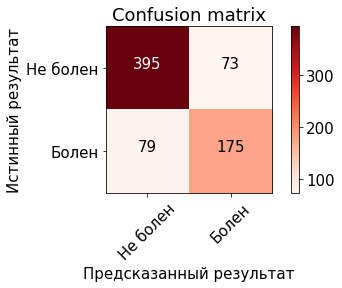

Precision = 0.7056451612903226
Recall = 0.6889763779527559
ROC-AUC = 0.766496735984925
F1 = 0.6972111553784861


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [13]:
hodel = xgboost.XGBClassifier().fit(train_data, train_result)
cnf_matrix = confusion_matrix(test_result, hodel.predict(test_data))
plot_confusion_matrix(cnf_matrix, classes=['Не болен', 'Болен'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_XGBoost.png")
plt.show()
print("Precision = {}".format(precision_score(test_result, hodel.predict(test_data))))
print("Recall = {}".format(recall_score(test_result, hodel.predict(test_data))))
print("ROC-AUC = {}".format(roc_auc_score(test_result, hodel.predict(test_data))))
print("F1 = {}".format(f1_score(test_result, hodel.predict(test_data))))

**Обучим модель 10 раз с различными сидами и усредним метрики:**

In [25]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
#Обучаем 10 раз и записываем метрики каждого раза
hodel_precision = []
hodel_recall = []
hodel_f1 = []
hodel_roc_auc = []
all_data=df.drop(labels=['target'],axis=1).fillna(0)
all_result=df['target'].fillna(0)
for i in range(0,10):    
    train_data_hodel, test_data_hodel, train_result_hodel, test_result_hodel = train_test_split(all_data,all_result, stratify=df['target'], random_state=int(seeds[i]))
    hodel = xgboost.XGBClassifier().fit(train_data_hodel, train_result_hodel)
    hodel_precision.append(precision_score(test_result_hodel, hodel.predict(test_data_hodel)))
    hodel_recall.append(recall_score(test_result_hodel, hodel.predict(test_data_hodel)))
    hodel_f1.append(f1_score(test_result_hodel, hodel.predict(test_data_hodel)))
    hodel_roc_auc.append(roc_auc_score(test_result_hodel, hodel.predict(test_data_hodel)))

#Складываем все метрики
precision_sum = 0
recall_sum = 0
f1_sum = 0
roc_auc_sum = 0
for i in range(0,10):
    precision_sum += hodel_precision[i]
    recall_sum += hodel_recall[i]
    f1_sum += hodel_f1[i]
    roc_auc_sum += hodel_roc_auc[i]

#Находим среднее
precision_average = precision_sum/10
recall_average = recall_sum/10
f1_average = f1_sum/10
roc_auc_average = roc_auc_sum/10

#Находим сумму квадратов разности между средним и каждым i-тым результатом
precision_sqr_sum = 0
recall_sqr_sum = 0
f1_sqr_sum = 0
roc_auc_sum = 0
for i in range(0,10):
    precision_sqr_sum += (precision_average - hodel_precision[i])**2
    recall_sqr_sum += (recall_average - hodel_recall[i])**2
    f1_sqr_sum += (f1_average - hodel_f1[i])**2
    roc_auc_sum += (roc_auc_average - hodel_roc_auc[i])**2

#Находим погрешность каждой метрики
precision_average_pogr = (precision_sqr_sum/10)**0.5
recall_average_pogr = (recall_sqr_sum/10)**0.5
f1_average_pogr = (f1_sqr_sum/10)**0.5
roc_auc_average_pogr = (roc_auc_sum/10)**0.5

#Выводим результат
print('Precision = {}'.format(precision_average) + ' +- {}'.format(precision_average_pogr))
print('Recall = {}'.format(recall_average) + ' +- {}'.format(recall_average_pogr))
print('F1 = {}'.format(f1_average) + ' +- {}'.format(f1_average_pogr))
print('ROC-AUC = {}'.format(roc_auc_average) + ' +- {}'.format(roc_auc_average_pogr))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:23:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:23:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:23:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:23:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:23:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:23:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:23:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision = 0.7091044558874642 +- 0.024872473818689112
Recall = 0.7244094488188976 +- 0.021274419033238273
F1 = 0.7163162822502762 +- 0.01709624494298446
ROC-AUC = 0.7812218184265428 +- 0.013505521100199348


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


**Permutation importance для XGBoost:**

In [26]:
perm = PermutationImportance(hodel).fit(test_data,test_result)
table = eli5.show_weights(perm,feature_names=df.drop(labels=['target'],axis=1).columns.tolist(),top=30)
result3 = pd.read_html(table.data)[0]
table

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

**Проверим на устойчивость:**

In [27]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
names=df.drop(labels=['target'], axis=1).columns.tolist()
sustain_counter_xgboost_pi = dict.fromkeys(names)
for i in range(0, len(names)):
    sustain_counter_xgboost_pi[names[i]] = []

for i in range(0, 10):
    train_data_xgboost_pi, test_data_xgboost_pi, train_result_xgboost_pi, test_result_xgboost_pi = train_test_split(all_data, all_result, test_size=0.3, random_state=int(seeds[i]))
    hodel = xgboost.XGBClassifier().fit(train_data_xgboost_pi, train_result_xgboost_pi)
    perm = PermutationImportance(hodel).fit(test_data_xgboost_pi, test_result_xgboost_pi)
    table_xgboost_pi = eli5.show_weights(perm, feature_names=names, top=85)
    result_xgboost_pi = pd.read_html(table_xgboost_pi.data)[0]
    for i in range(0,len(names)):
        sustain_counter_xgboost_pi[result_xgboost_pi['Feature'][i]].append(i)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:23:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

[17:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

[17:24:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

[17:24:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

[17:24:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

[17:24:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

[17:24:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

[17:24:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

[17:24:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:24:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

**Посчитаем среднее место каждого нутриента в списке и стандартное отклонение от этого значения:**

In [28]:
sum_xgboost_pi = {}
pogr_xgboost_pi = {}
for i in range(0,len(names)):
        sum_xgboost_pi[names[i]] = np.mean(sustain_counter_xgboost_pi[names[i]])
        pogr_xgboost_pi[names[i]] = np.std(sustain_counter_xgboost_pi[names[i]])
for i in range(0,len(names)):
    print(names[i],': ',sum_xgboost_pi[names[i]],' ',pogr_xgboost_pi[names[i]])

возраст :  0.6   0.48989794855663565
пол :  50.4   19.21041384249699
масса_тела :  17.8   19.988996973335105
рост :  44.1   26.84939477902621
от :  33.3   33.358806933102386
об :  56.2   15.354478174135389
оп :  24.9   12.218428704215613
жм :  21.6   19.50487118644981
мм :  50.8   24.132136250236943
ож :  30.5   18.3698121928342
внутриклеточная_жидкость :  47.2   22.842066456430775
тощая_мт :  44.5   19.236683705878203
акм :  42.4   17.083325203250098
холестерин :  33.2   26.995555189697434
нас._жир :  54.4   19.48948434412773
натрий_na :  31.9   23.304291450288723
сахара :  46.1   25.24460338369371
энергия :  23.3   17.793538152936307
вода :  38.7   24.462420158275428
пищ._волокна :  41.1   23.06274051365102
мононенас._жир :  36.6   19.334942461771124
белки :  36.7   16.352675622050356
аргинин :  51.6   22.654800815721156
валин :  51.4   18.58601624878231
зола :  41.7   20.233882474700696
полиненас._жир :  42.7   25.393109301540843
калий_k :  46.6   22.952995447217777
крахмал :  37.5 

**SHAP для XGBoost:**

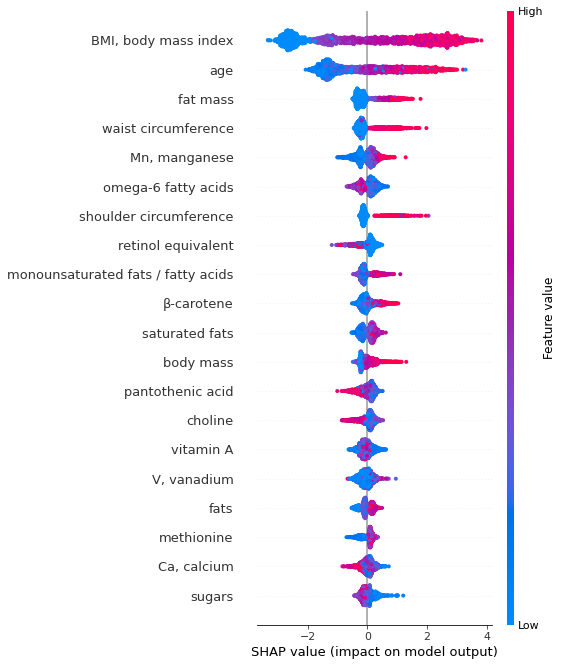

In [14]:
explainer = shap.Explainer(hodel, train_data)
shap_values2 = explainer(train_data)
shap.summary_plot(shap_values2, features=None, feature_names=train_data.columns.tolist(), max_display=None, plot_type=None, 
                  color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, 
                  plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None)
spisok3 = train_data.columns[np.argsort(np.abs(shap_values2.values).mean(0))].tolist()

**Проверим на устойчивость SHAP:**

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:25:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 94%|=================== | 1899/2019 [00:16<00:01]       

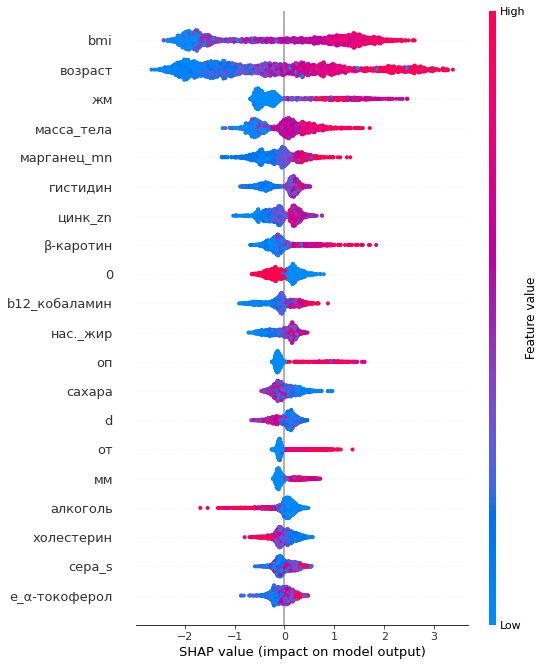

[17:25:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 98%|===================| 1982/2019 [00:16<00:00]        

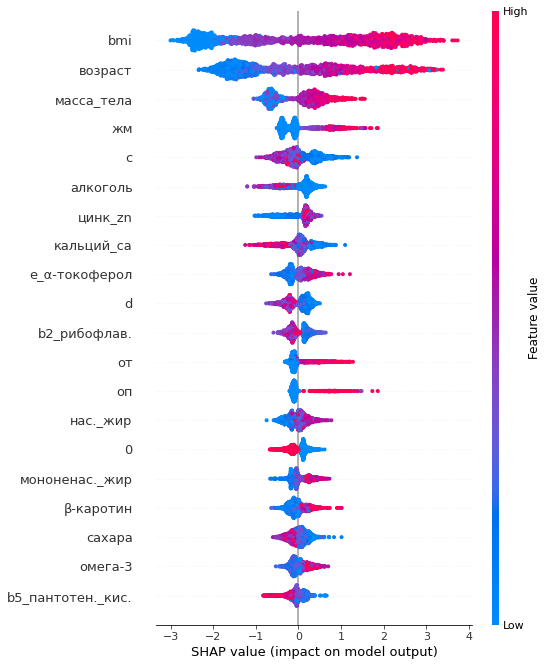

[17:25:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 98%|===================| 1977/2019 [00:16<00:00]        

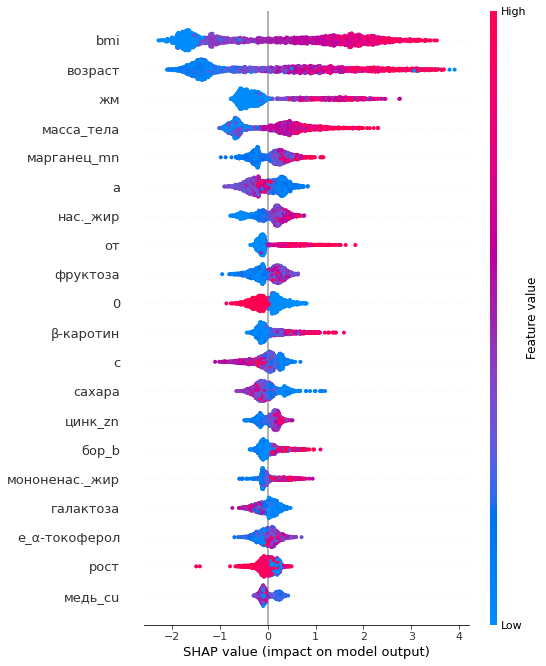

[17:25:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 95%|=================== | 1920/2019 [00:16<00:00]       

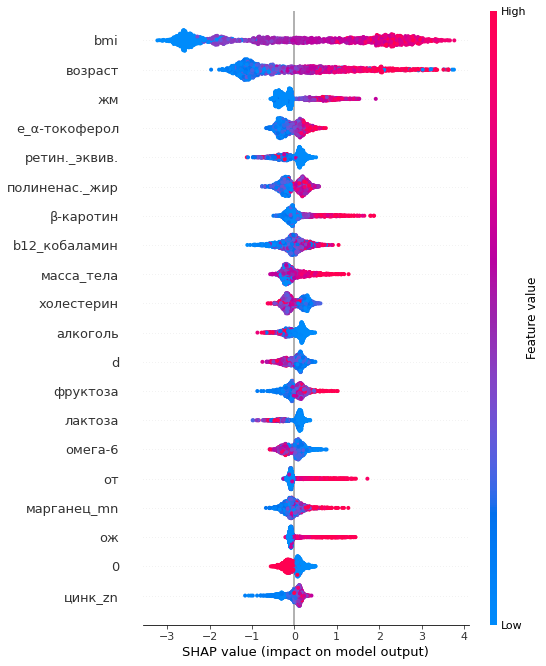

[17:26:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 96%|=================== | 1941/2019 [00:16<00:00]       

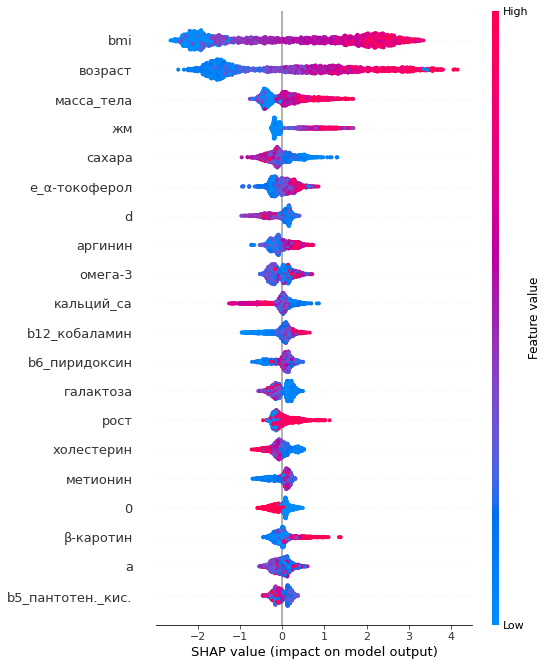

[17:26:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 95%|=================== | 1926/2019 [00:16<00:00]       

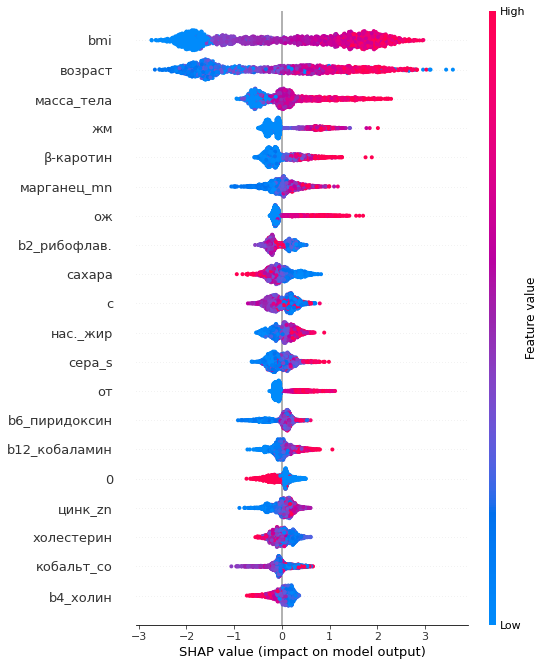

[17:26:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 96%|=================== | 1933/2019 [00:15<00:00]       

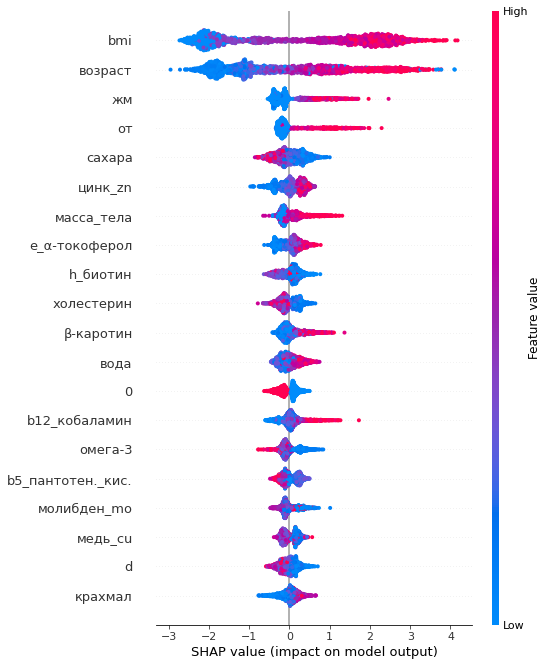

[17:27:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 95%|=================== | 1925/2019 [00:16<00:00]       

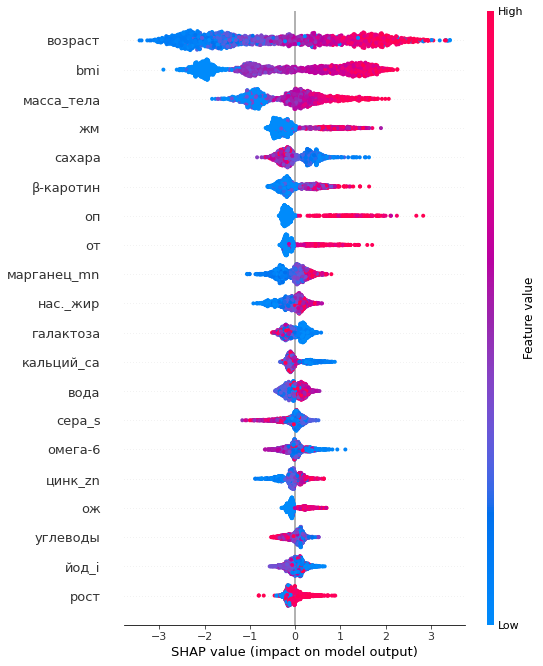

[17:27:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 95%|=================== | 1912/2019 [00:15<00:00]       

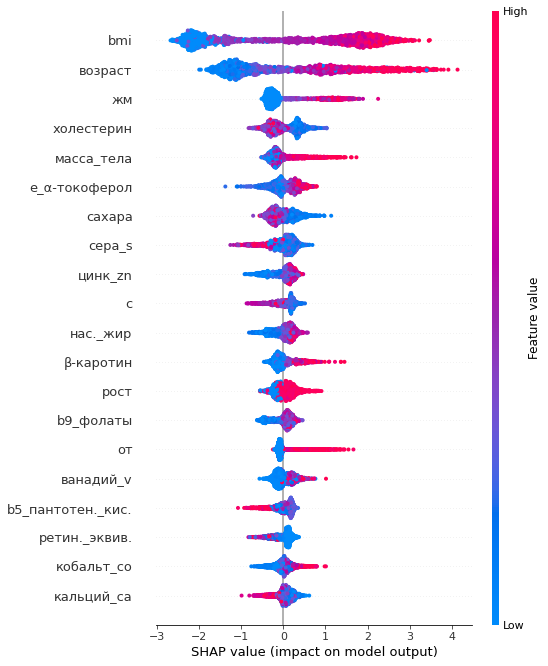

[17:27:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 99%|===================| 1992/2019 [00:15<00:00]        

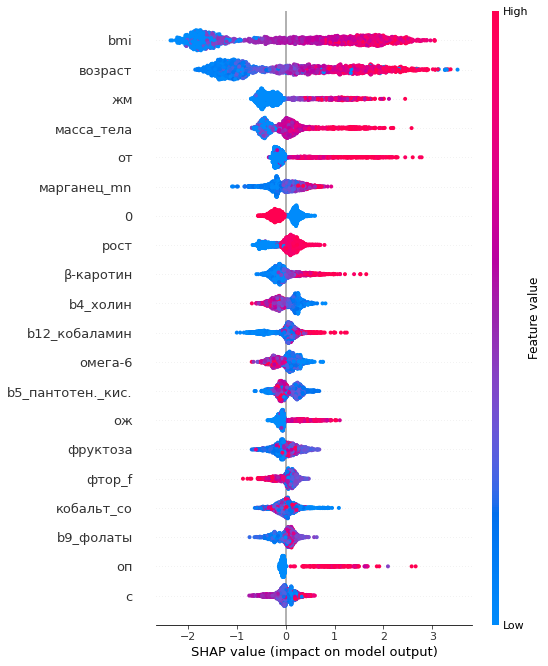

In [30]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
names = df.drop(labels=['target'],axis=1).columns.tolist()
sustain_counter_xgboost_shap = dict.fromkeys(names)
for i in range(0,len(names)):
    sustain_counter_xgboost_shap[names[i]]=[]
for i in range(0,10):
    train_data_xgboost_shap, test_data_xgboost_shap, train_result_xgboost_shap, test_result_xgboost_shap = train_test_split(all_data, all_result, test_size=0.3, random_state=int(seeds[i]))
    hodel = xgboost.XGBClassifier().fit(train_data_xgboost_shap, train_result_xgboost_shap)
    explainer = shap.Explainer(hodel, train_data_xgboost_shap)
    shap_values2 = explainer(train_data_xgboost_shap)
    shap.summary_plot(shap_values2, features=None, feature_names=train_data.columns.tolist(), max_display=None, plot_type=None, 
                      color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, 
                      plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None)
    spisok3 = train_data.columns[np.argsort(np.abs(shap_values2.values).mean(0))].tolist()
    for counter in range(0,len(names)):
        sustain_counter_xgboost_shap[spisok3[counter]].append(84-counter)

**Посчитаем среднее место каждого нутриента в списке и стандартное отклонение от этого значения:**

In [31]:
sum_xgboost_shap = {}
pogr_xgboost_shap = {}
for i in range(0,len(names)):
        sum_xgboost_shap[names[i]] = np.mean(sustain_counter_xgboost_shap[names[i]])
        pogr_xgboost_shap[names[i]] = np.std(sustain_counter_xgboost_shap[names[i]])
for i in range(0,len(names)):
    print(names[i],': ',sum_xgboost_shap[names[i]],' ',pogr_xgboost_shap[names[i]])

возраст :  0.9   0.30000000000000004
пол :  73.9   8.688498144098324
масса_тела :  3.5   1.91049731745428
рост :  29.9   17.91898434621784
от :  11.9   7.8287930104199335
об :  61.0   14.021412197064887
оп :  25.3   15.843295111813072
жм :  2.4   0.48989794855663565
мм :  46.4   21.950854197502203
ож :  39.9   23.564592082189755
внутриклеточная_жидкость :  74.6   4.586937976471886
тощая_мт :  60.8   17.943243853885505
акм :  72.0   10.564090116995406
холестерин :  18.6   10.95627673984187
нас._жир :  17.3   9.879777325425913
натрий_na :  40.9   10.63437821407533
сахара :  10.7   6.165225056719341
энергия :  51.2   13.541048703848606
вода :  35.2   16.951696080333672
пищ._волокна :  49.0   8.555699854482976
мононенас._жир :  36.1   16.85496959356498
белки :  51.7   18.433936096232948
аргинин :  39.1   16.789580101956094
валин :  73.6   5.083306010855534
зола :  62.6   12.63487237766967
полиненас._жир :  41.4   17.60795274868717
калий_k :  49.3   12.99269025259973
крахмал :  32.1   9.137

**CatBoost:**

In [15]:
catboost1=CatBoostClassifier(verbose=0, logging_level=None).fit(train_data, train_result)

Confusion matrix, without normalization
[[398  70]
 [ 66 188]]


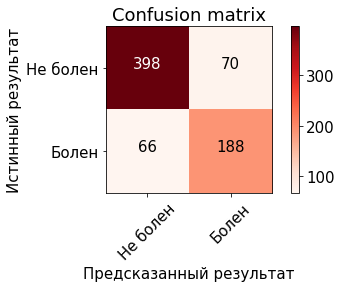

Precision = 0.7286821705426356
Recall = 0.7401574803149606
ROC-AUC = 0.7952924153711555
F1 = 0.7343749999999999


In [16]:
cnf_matrix = confusion_matrix(test_result, catboost1.predict(test_data))
plot_confusion_matrix(cnf_matrix, classes=['Не болен', 'Болен'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_catboost.png")
plt.show()
print("Precision = {}".format(precision_score(test_result, catboost1.predict(test_data))))
print("Recall = {}".format(recall_score(test_result, catboost1.predict(test_data))))
print("ROC-AUC = {}".format(roc_auc_score(test_result, catboost1.predict(test_data))))
print("F1 = {}".format(f1_score(test_result, catboost1.predict(test_data))))

**Обучим модель 10 раз с различными сидами и усредним метрики:**

In [34]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
#Обучаем 10 раз и записываем метрики каждого раза
catboost1_precision = []
catboost1_recall = []
catboost1_f1 = []
catboost1_roc_auc = []
all_data=df.drop(labels=['target'],axis=1).fillna(0)
all_result=df['target'].fillna(0)
for i in range(0,10):    
    train_data_catboost1, test_data_catboost1, train_result_catboost1, test_result_catboost1 = train_test_split(all_data,all_result, stratify=df['target'], random_state=int(seeds[i]))
    catboost1 = CatBoostClassifier(verbose=0,logging_level=None).fit(train_data_catboost1,train_result_catboost1)
    catboost1_precision.append(precision_score(test_result_catboost1, catboost1.predict(test_data_catboost1)))
    catboost1_recall.append(recall_score(test_result_catboost1, catboost1.predict(test_data_catboost1)))
    catboost1_f1.append(f1_score(test_result_catboost1, catboost1.predict(test_data_catboost1)))
    catboost1_roc_auc.append(roc_auc_score(test_result_catboost1, catboost1.predict(test_data_catboost1)))

#Складываем все метрики
precision_sum = 0
recall_sum = 0
f1_sum = 0
roc_auc_sum = 0
for i in range(0,10):
    precision_sum += catboost1_precision[i]
    recall_sum += catboost1_recall[i]
    f1_sum += catboost1_f1[i]
    roc_auc_sum += catboost1_roc_auc[i]

#Находим среднее
precision_average = precision_sum/10
recall_average = recall_sum/10
f1_average = f1_sum/10
roc_auc_average = roc_auc_sum/10

#Находим сумму квадратов разности между средним и каждым i-тым результатом
precision_sqr_sum = 0
recall_sqr_sum = 0
f1_sqr_sum = 0
roc_auc_sum = 0
for i in range(0,10):
    precision_sqr_sum += (precision_average - catboost1_precision[i])**2
    recall_sqr_sum += (recall_average - catboost1_recall[i])**2
    f1_sqr_sum += (f1_average - catboost1_f1[i])**2
    roc_auc_sum += (roc_auc_average - catboost1_roc_auc[i])**2

#Находим погрешность каждой метрики
precision_average_pogr = (precision_sqr_sum/10)**0.5
recall_average_pogr = (recall_sqr_sum/10)**0.5
f1_average_pogr = (f1_sqr_sum/10)**0.5
roc_auc_average_pogr = (roc_auc_sum/10)**0.5

#Выводим результат
print('Precision = {}'.format(precision_average) + ' +- {}'.format(precision_average_pogr))
print('Recall = {}'.format(recall_average) + ' +- {}'.format(recall_average_pogr))
print('F1 = {}'.format(f1_average) + ' +- {}'.format(f1_average_pogr))
print('ROC-AUC = {}'.format(roc_auc_average) + ' +- {}'.format(roc_auc_average_pogr))

Precision = 0.7325000530238972 +- 0.018242137213183348
Recall = 0.7570866141732283 +- 0.01430927704361122
F1 = 0.7443953489353575 +- 0.011390601226959176
ROC-AUC = 0.8033296318729389 +- 0.008894691506868044


**Permutation Importance для CatBoost:**

In [35]:
perm = PermutationImportance(catboost1, random_state=1).fit(test_data, test_result)
table = eli5.show_weights(perm, feature_names=train_data.columns.tolist(), top=30)
result4 = pd.read_html(table.data)[0]
table

**Проверим на устойчивость:**

In [36]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
names=df.drop(labels=['target'],axis=1).columns.tolist()
sustain_counter_catboost_pi = dict.fromkeys(names)
for i in range(0,len(names)):
    sustain_counter_catboost_pi[names[i]] = []

for i in range(0,10):
    train_data_catboost_pi, test_data_catboost_pi, train_result_catboost_pi, test_result_catboost_pi = train_test_split(all_data, all_result, test_size=0.3, random_state=int(seeds[i]))
    catboost1 = CatBoostClassifier(verbose=0,logging_level=None).fit(train_data_catboost_pi, train_result_catboost_pi)
    perm = PermutationImportance(catboost1).fit(test_data_catboost_pi, test_result_catboost_pi)
    table_catboost_pi = eli5.show_weights(perm, feature_names=names, top=85)
    result_catboost_pi = pd.read_html(table_catboost_pi.data)[0]
    for i in range(0,len(names)):
        sustain_counter_catboost_pi[result_catboost_pi['Feature'][i]].append(i)

**Посчитаем среднее место каждого нутриента в списке и стандартное отклонение от этого значения:**

In [37]:
sum_catboost_pi = {}
pogr_catboost_pi = {}
for i in range(0,len(names)):
        sum_catboost_pi[names[i]] = np.mean(sustain_counter_catboost_pi[names[i]])
        pogr_catboost_pi[names[i]] = np.std(sustain_counter_catboost_pi[names[i]])
for i in range(0,len(names)):
    print(names[i],': ',sum_catboost_pi[names[i]],' ',pogr_catboost_pi[names[i]])

возраст :  0.2   0.4000000000000001
пол :  52.1   12.762836675285005
масса_тела :  16.4   26.893121797217965
рост :  23.1   20.359027481684876
от :  47.2   26.324133414036634
об :  53.7   19.51947745202212
оп :  17.0   14.057026712644463
жм :  30.8   35.17897099120439
мм :  37.7   22.041097976280582
ож :  19.9   13.545848072379965
внутриклеточная_жидкость :  34.6   22.190989162270345
тощая_мт :  33.0   17.227884373886425
акм :  41.1   22.818632737304835
холестерин :  15.6   21.786234185833955
нас._жир :  56.9   23.85979882563975
натрий_na :  42.0   18.16590212458495
сахара :  35.5   21.1482859825566
энергия :  51.0   18.21537811850196
вода :  48.3   23.575623003433016
пищ._волокна :  41.8   20.778835386036437
мононенас._жир :  53.0   21.283796653792763
белки :  61.4   8.272847151978574
аргинин :  37.8   22.79824554653274
валин :  49.4   17.00117642988273
зола :  54.1   20.544829033116823
полиненас._жир :  48.8   21.50255798736513
калий_k :  30.4   17.704236781064584
крахмал :  36.8   1

**SHAP для CatBoost:**

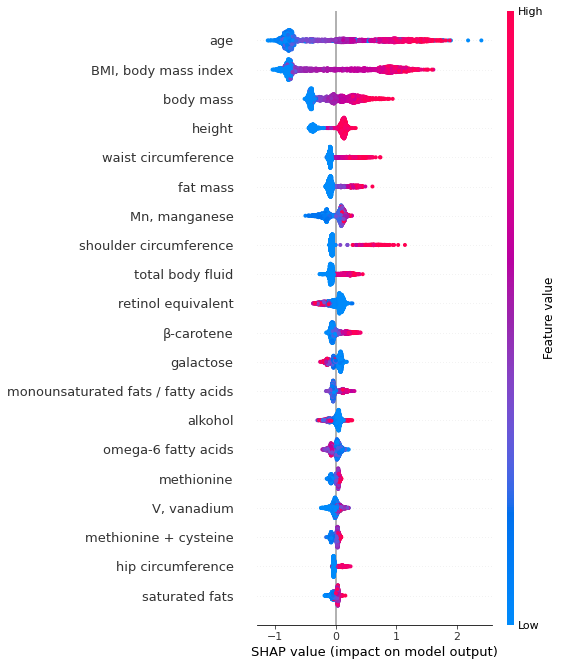

In [17]:
explainer = shap.TreeExplainer(catboost1)
shap_values3 = explainer.shap_values(train_data)
shap.summary_plot(shap_values3, features=train_data, feature_names=train_data.columns.tolist(), max_display=None, plot_type=None, 
                  color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, 
                  plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None)
spisok4 = train_data.columns[np.argsort(np.abs(shap_values3).mean(0))].tolist()

**Проверим на устойчивость SHAP:**

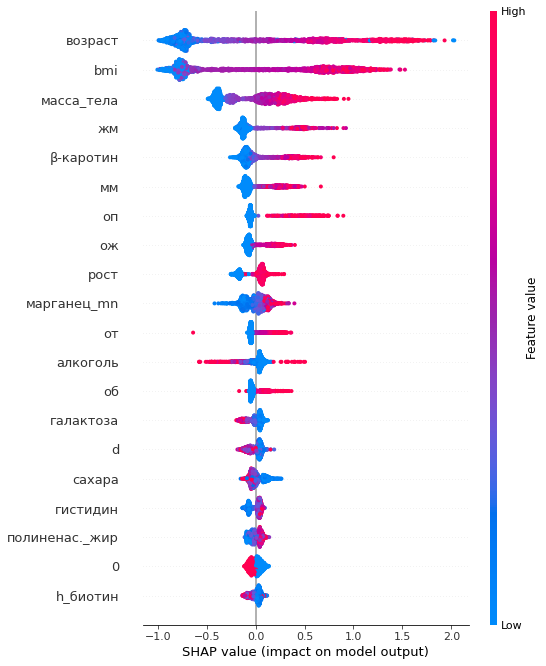

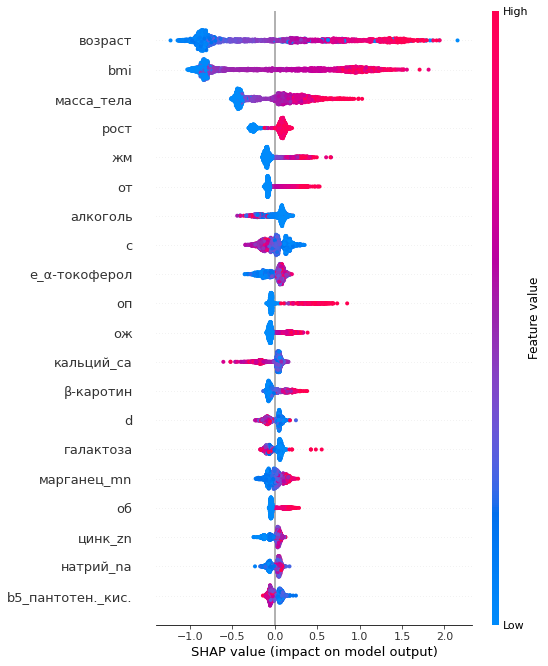

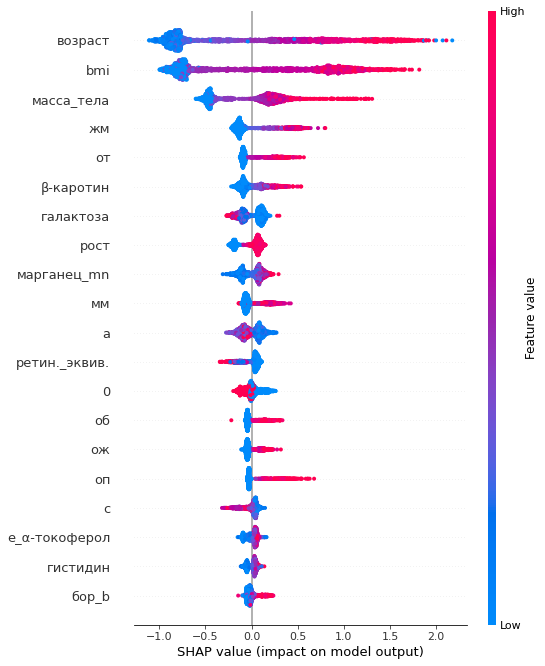

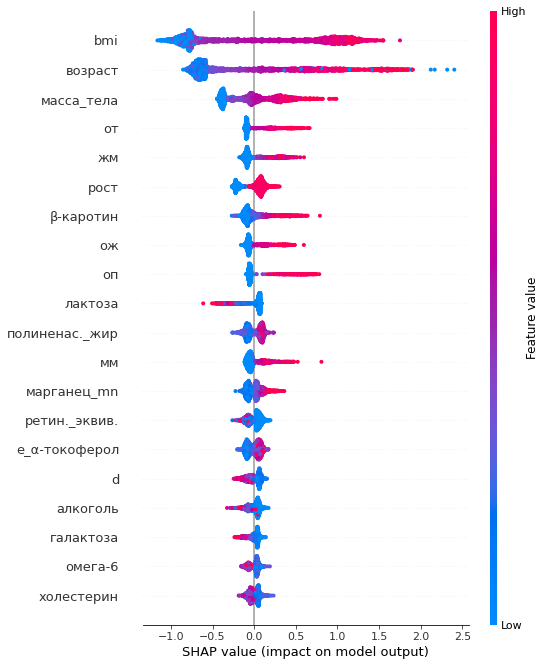

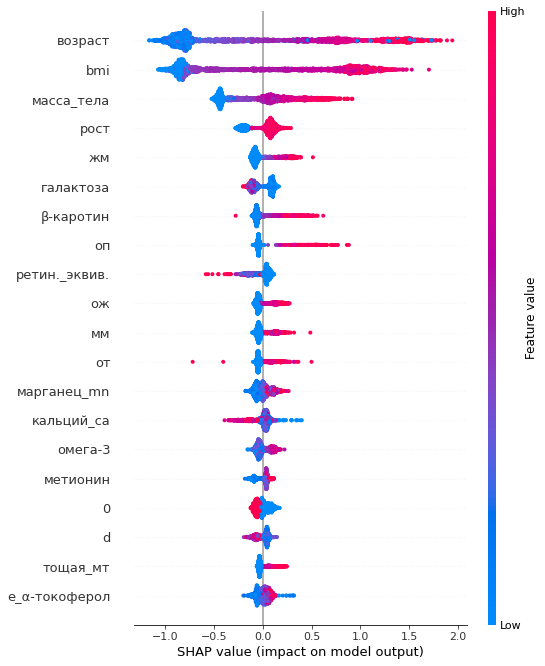

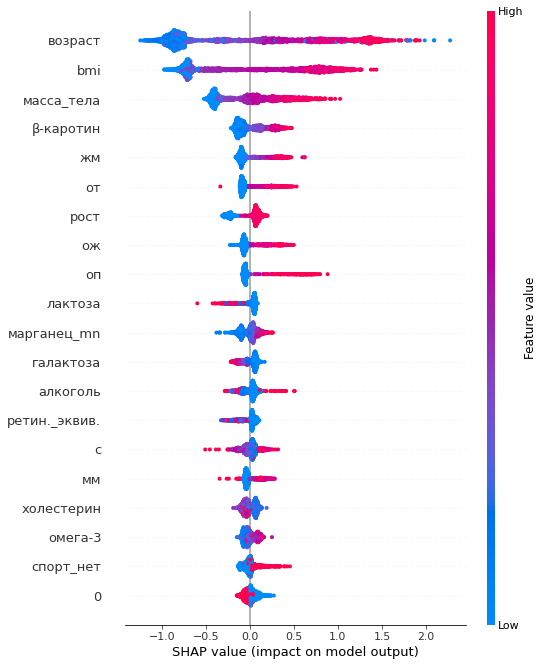

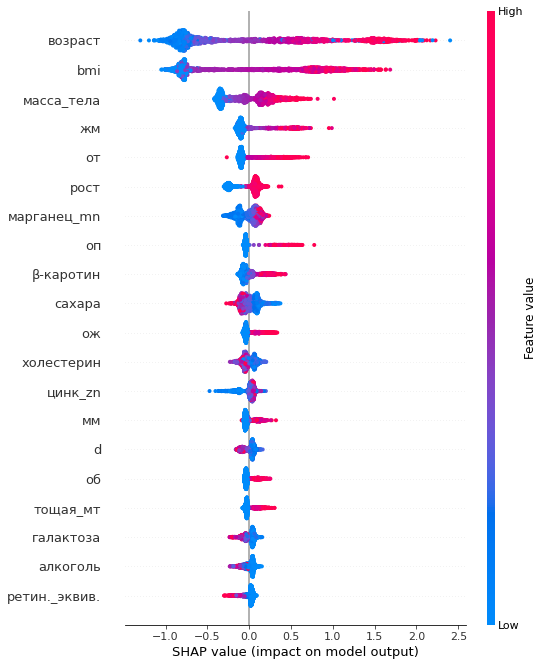

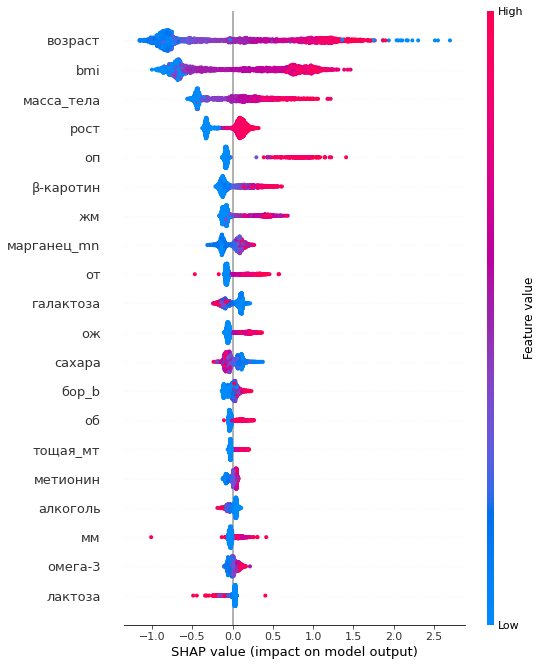

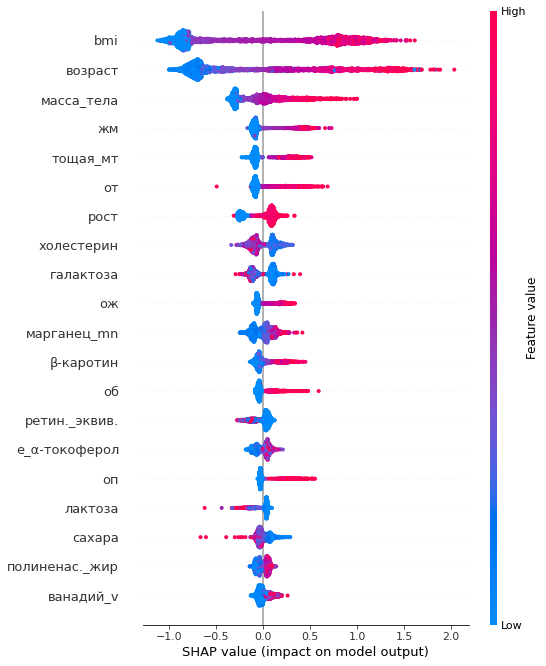

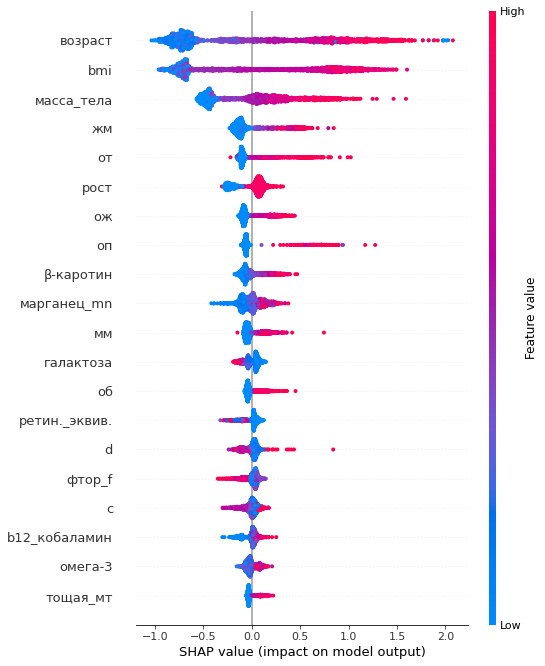

In [39]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
names = df.drop(labels=['target'],axis=1).columns.tolist()
sustain_counter_catboost_shap = dict.fromkeys(names)
for i in range(0,len(names)):
    sustain_counter_catboost_shap[names[i]]=[]
for i in range(0,10):
    train_data_catboost_shap, test_data_catboost_shap, train_result_catboost_shap, test_result_catboost_shap = train_test_split(all_data, all_result, test_size=0.3, random_state=int(seeds[i]))
    catboost1=CatBoostClassifier(verbose=0, logging_level=None).fit(train_data_catboost_shap, train_result_catboost_shap)
    explainer = shap.TreeExplainer(catboost1)
    shap_values3 = explainer.shap_values(train_data_catboost_shap)
    shap.summary_plot(shap_values3, features=train_data_catboost_shap, feature_names=train_data_catboost_shap.columns.tolist(), max_display=None, plot_type=None, 
                  color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, 
                  plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None)
    spisok4 = train_data_catboost_shap.columns[np.argsort(np.abs(shap_values3).mean(0))].tolist()
    for counter in range(0,len(names)):
        sustain_counter_catboost_shap[spisok4[counter]].append(84-counter)

**Посчитаем среднее место каждого нутриента в списке и стандартное отклонение от этого значения:**

In [40]:
sum_catboost_shap = {}
pogr_catboost_shap = {}
for i in range(0,len(names)):
        sum_catboost_shap[names[i]] = np.mean(sustain_counter_catboost_shap[names[i]])
        pogr_catboost_shap[names[i]] = np.std(sustain_counter_catboost_shap[names[i]])
for i in range(0,len(names)):
    print(names[i],': ',sum_catboost_shap[names[i]],' ',pogr_catboost_shap[names[i]])

возраст :  0.2   0.4000000000000001
пол :  82.5   3.2326459750489227
масса_тела :  2.0   0.0
рост :  5.1   1.6401219466856727
от :  5.9   2.6248809496813377
об :  16.4   5.102940328869229
оп :  8.6   3.4409301068170506
жм :  3.7   0.9
мм :  15.0   8.87693640846886
ож :  8.9   2.211334438749598
внутриклеточная_жидкость :  57.4   10.18037327409953
тощая_мт :  20.8   9.4
акм :  67.8   17.063411147833246
холестерин :  29.4   13.994284547628721
нас._жир :  33.3   8.149233092751734
натрий_na :  45.4   12.499599993599796
сахара :  20.4   6.740919818541087
энергия :  76.7   3.287856444554719
вода :  47.6   15.16047492659778
пищ._волокна :  60.4   11.33313725320575
мононенас._жир :  48.6   11.791522378386938
белки :  67.8   7.922120928135344
аргинин :  57.4   13.979985693841035
валин :  51.3   6.928924880528004
зола :  73.4   9.90151503558925
полиненас._жир :  21.7   6.4815121692395214
калий_k :  70.8   14.05560386465128
крахмал :  47.9   15.475464451834718
гистидин :  40.0   18.718974330876144

**LightGBM:**

In [48]:
from lightgbm import LGBMClassifier

In [63]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [83]:
alg =LGBMClassifier().fit(train_data,train_result)

Confusion matrix, without normalization
[[400  68]
 [ 71 183]]


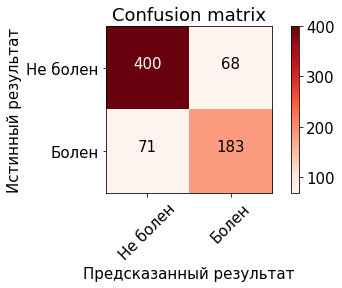

Precision = 0.7290836653386454
Recall = 0.7204724409448819
ROC-AUC = 0.7875866478228682
F1 = 0.7247524752475247


In [84]:
cnf_matrix = confusion_matrix(test_result, alg.predict(test_data))
plot_confusion_matrix(cnf_matrix, classes=['Не болен', 'Болен'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_lgbm.png")
plt.show()
print("Precision = {}".format(precision_score(test_result, alg.predict(test_data))))
print("Recall = {}".format(recall_score(test_result, alg.predict(test_data))))
print("ROC-AUC = {}".format(roc_auc_score(test_result, alg.predict(test_data))))
print("F1 = {}".format(f1_score(test_result, alg.predict(test_data))))

**Обучим модель 10 раз с различными сидами и усредним метрики:**

In [44]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
#Обучаем 10 раз и записываем метрики каждого раза
alg_precision = []
alg_recall = []
alg_f1 = []
alg_roc_auc = []
all_data=df.drop(labels=['target'],axis=1).fillna(0)
all_result=df['target'].fillna(0)
for i in range(0,10):    
    train_data_alg, test_data_alg, train_result_alg, test_result_alg = train_test_split(all_data,all_result, stratify=df['target'], random_state=int(seeds[i]))
    alg = LGBMClassifier().fit(train_data_alg,train_result_alg)
    alg_precision.append(precision_score(test_result_alg, alg.predict(test_data_alg)))
    alg_recall.append(recall_score(test_result_alg, alg.predict(test_data_alg)))
    alg_f1.append(f1_score(test_result_alg, alg.predict(test_data_alg)))
    alg_roc_auc.append(roc_auc_score(test_result_alg, alg.predict(test_data_alg)))

#Складываем все метрики
precision_sum = 0
recall_sum = 0
f1_sum = 0
roc_auc_sum = 0
for i in range(0,10):
    precision_sum += alg_precision[i]
    recall_sum += alg_recall[i]
    f1_sum += alg_f1[i]
    roc_auc_sum += alg_roc_auc[i]

#Находим среднее
precision_average = precision_sum/10
recall_average = recall_sum/10
f1_average = f1_sum/10
roc_auc_average = roc_auc_sum/10

#Находим сумму квадратов разности между средним и каждым i-тым результатом
precision_sqr_sum = 0
recall_sqr_sum = 0
f1_sqr_sum = 0
roc_auc_sum = 0
for i in range(0,10):
    precision_sqr_sum += (precision_average - alg_precision[i])**2
    recall_sqr_sum += (recall_average - alg_recall[i])**2
    f1_sqr_sum += (f1_average - alg_f1[i])**2
    roc_auc_sum += (roc_auc_average - alg_roc_auc[i])**2

#Находим погрешность каждой метрики
precision_average_pogr = (precision_sqr_sum/10)**0.5
recall_average_pogr = (recall_sqr_sum/10)**0.5
f1_average_pogr = (f1_sqr_sum/10)**0.5
roc_auc_average_pogr = (roc_auc_sum/10)**0.5

#Выводим результат
print('Precision = {}'.format(precision_average) + ' +- {}'.format(precision_average_pogr))
print('Recall = {}'.format(recall_average) + ' +- {}'.format(recall_average_pogr))
print('F1 = {}'.format(f1_average) + ' +- {}'.format(f1_average_pogr))
print('ROC-AUC = {}'.format(roc_auc_average) + ' +- {}'.format(roc_auc_average_pogr))

Precision = 0.7104025555590827 +- 0.022859294347973423
Recall = 0.7283464566929133 +- 0.016422561901271043
F1 = 0.7189661739922042 +- 0.013669847443915478
ROC-AUC = 0.7832971599703884 +- 0.01067529156111893


**Permutation Importance для LightGBM:**

In [45]:
perm=PermutationImportance(alg,random_state=1).fit(test_data,test_result)
table = eli5.show_weights(perm,feature_names=df.drop(labels=['target'],axis=1).columns.tolist(),top=30)
result5 = pd.read_html(table.data)[0]
table

**Проверим на устойчивость:**

In [46]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
names=df.drop(labels=['target'],axis=1).columns.tolist()
sustain_counter_lightgbm_pi = dict.fromkeys(names)
for i in range(0,len(names)):
    sustain_counter_lightgbm_pi[names[i]] = []

for i in range(0,10):
    train_data_lightgbm_pi, test_data_lightgbm_pi, train_result_lightgbm_pi, test_result_lightgbm_pi = train_test_split(all_data, all_result, test_size=0.3, random_state=int(seeds[i]))
    alg =LGBMClassifier().fit(train_data_lightgbm_pi, train_result_lightgbm_pi)
    perm = PermutationImportance(alg).fit(test_data_lightgbm_pi, test_result_lightgbm_pi)
    table_lightgbm_pi = eli5.show_weights(perm, feature_names=names, top=85)
    result_lightgbm_pi = pd.read_html(table_lightgbm_pi.data)[0]
    for i in range(0,len(names)):
        sustain_counter_lightgbm_pi[result_lightgbm_pi['Feature'][i]].append(i)

**Посчитаем среднее место каждого нутриента в списке и стандартное отклонение от этого значения:**

In [47]:
sum_lightgbm_pi={}
pogr_lightgbm_pi={}
for i in range(0,len(names)):
        sum_lightgbm_pi[names[i]] = np.mean(sustain_counter_lightgbm_pi[names[i]])
        pogr_lightgbm_pi[names[i]] = np.std(sustain_counter_lightgbm_pi[names[i]])
for i in range(0,len(names)):
    print(names[i], ': ',sum_lightgbm_pi[names[i]],' ',pogr_lightgbm_pi[names[i]])

возраст :  0.5   0.5
пол :  41.5   17.414074767267998
масса_тела :  22.8   27.83451095313155
рост :  30.5   20.896171898220974
от :  35.9   26.591163945942647
об :  51.8   20.8269056751117
оп :  23.5   19.5
жм :  22.3   26.847904946196454
мм :  45.9   17.35770722186545
ож :  37.0   25.13961017995307
внутриклеточная_жидкость :  39.1   22.936651891677652
тощая_мт :  35.2   19.548913013259842
акм :  49.7   18.59596730476799
холестерин :  35.2   25.19047439013406
нас._жир :  57.7   18.8257801963159
натрий_na :  55.7   21.009759636892564
сахара :  38.4   22.70330372434814
энергия :  50.8   25.451129640941282
вода :  37.8   16.503332996701
пищ._волокна :  60.9   22.133458834985554
мононенас._жир :  52.3   22.43234272206093
белки :  44.2   27.025173449952177
аргинин :  48.6   27.886197302608327
валин :  49.9   16.446580191638628
зола :  31.8   19.01473113141493
полиненас._жир :  44.0   22.847319317591726
калий_k :  52.5   14.030324301312497
крахмал :  46.3   21.000238093888363
гистидин :  46.

**SHAP для LightGBM:**

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


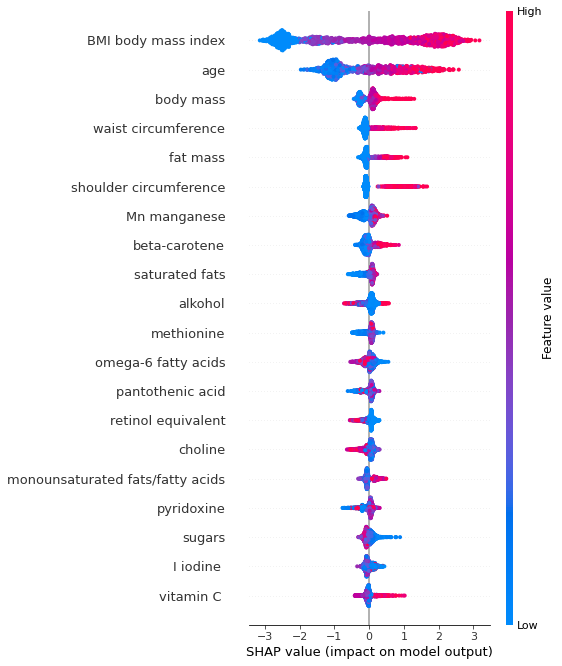

In [85]:
explainer = shap.TreeExplainer(alg)
shap_values4 =  explainer.shap_values(train_data)
shap.summary_plot(shap_values4[1], features=train_data, feature_names=train_data.columns.tolist(), max_display=None, plot_type=None, 
                  color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, 
                  plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None)
spisok5 = train_data.columns[np.argsort(np.abs(shap_values4[1]).mean(0))].tolist()

**Проверим на устойчивость SHAP:**

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


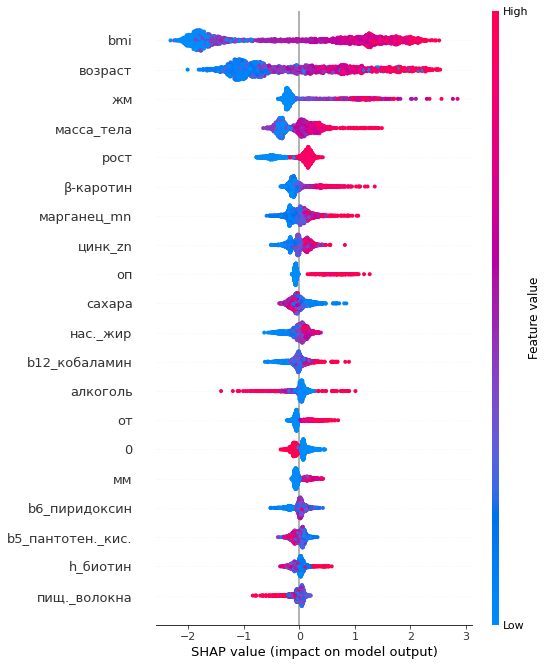

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


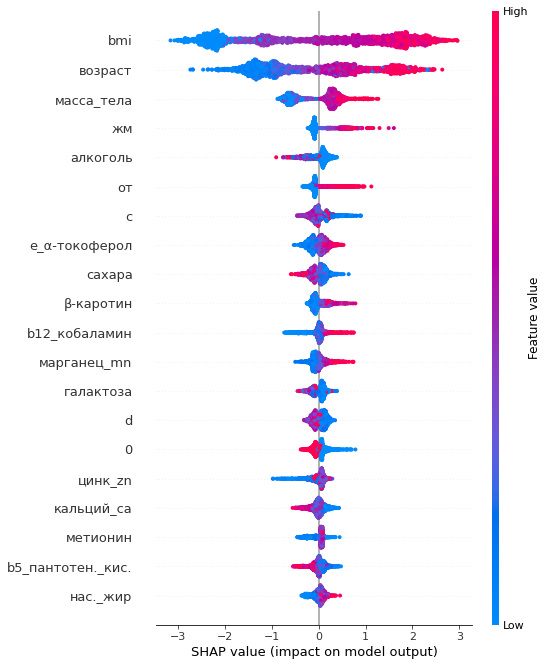

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


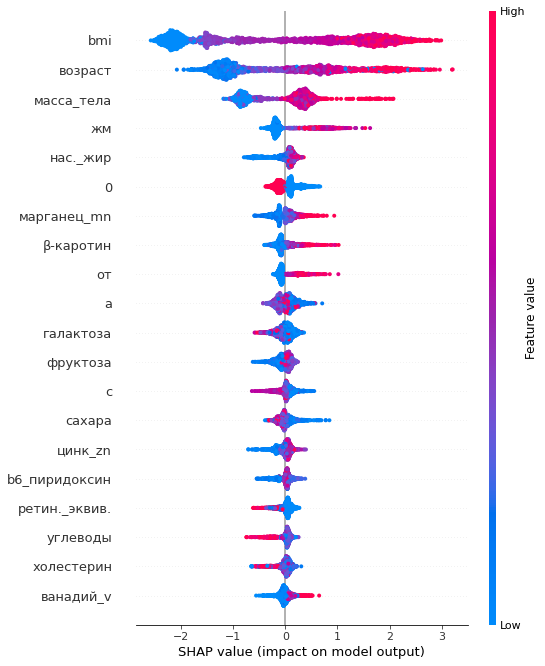

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


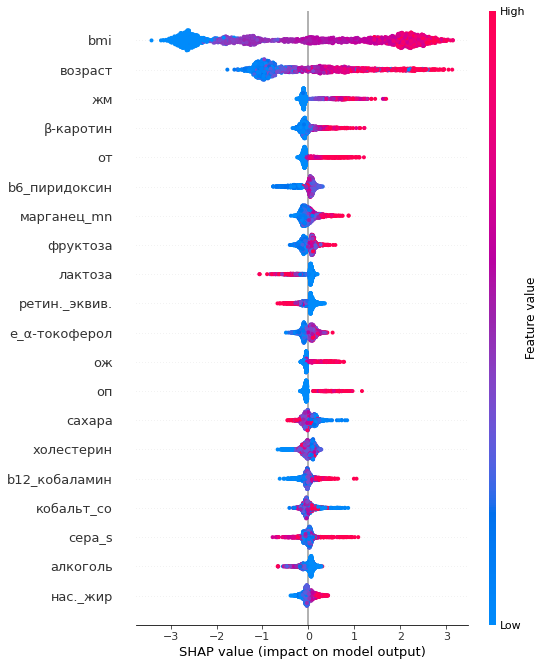

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


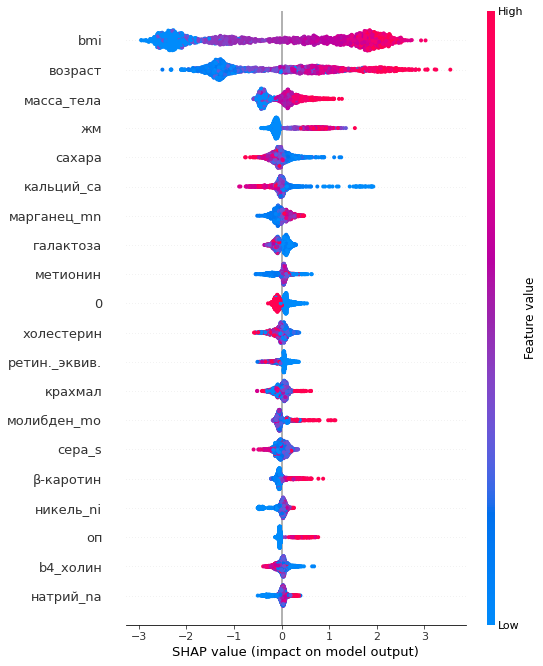

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


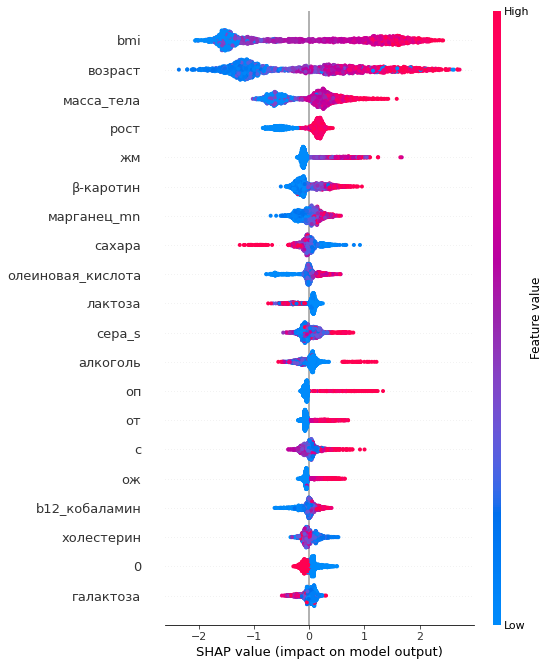

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


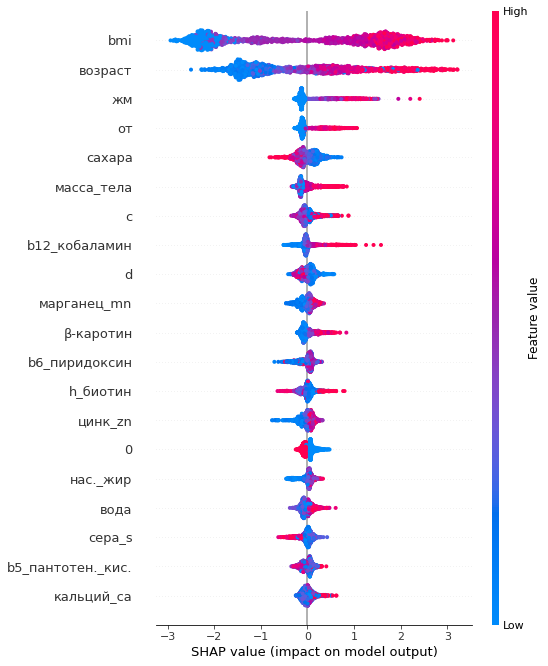

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


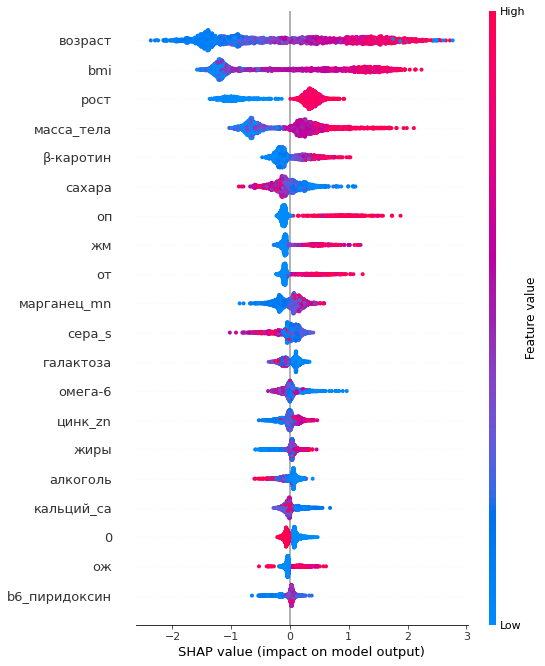

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


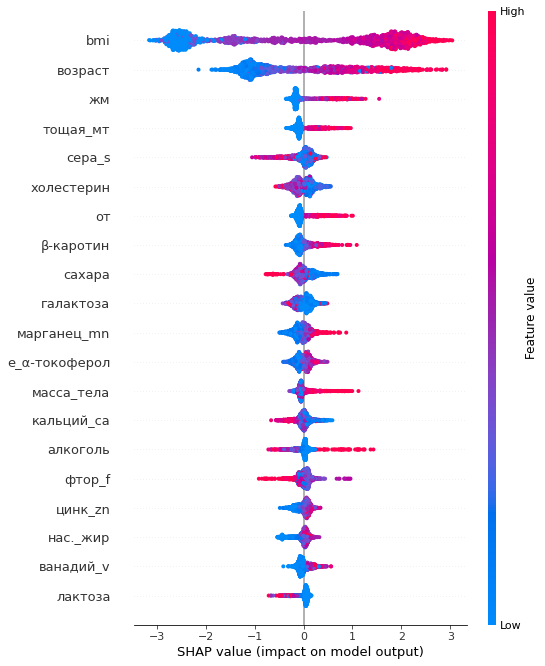

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


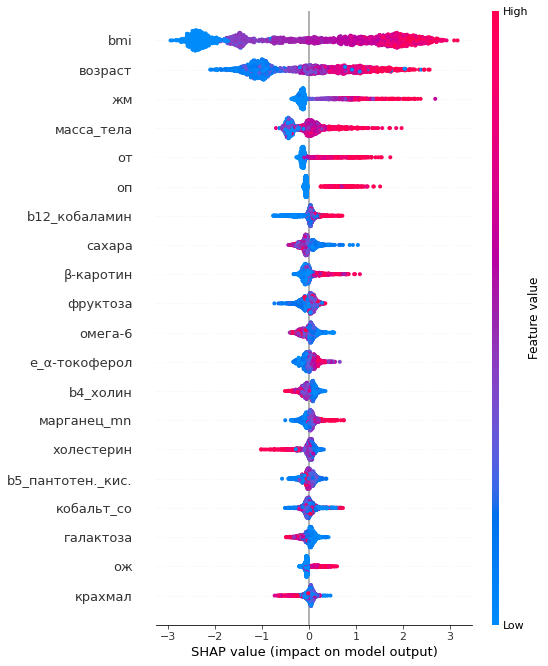

In [49]:
seeds = ['8', '12', '36', '42', '54', '68', '72', '86', '97', '23']
names = df.drop(labels=['target'],axis=1).columns.tolist()
sustain_counter_lightgbm_shap = dict.fromkeys(names)
for i in range(0,len(names)):
    sustain_counter_lightgbm_shap[names[i]]=[]
for i in range(0,10):
    train_data_lightgbm_shap, test_data_lightgbm_shap, train_result_lightgbm_shap, test_result_lightgbm_shap = train_test_split(all_data, all_result, test_size=0.3, random_state=int(seeds[i]))
    alg =LGBMClassifier().fit(train_data_lightgbm_shap, train_result_lightgbm_shap)
    explainer = shap.TreeExplainer(alg)
    shap_values4 =  explainer.shap_values(train_data_lightgbm_shap)
    shap.summary_plot(shap_values4[1], features=train_data_lightgbm_shap, feature_names=train_data_lightgbm_shap.columns.tolist(), max_display=None, plot_type=None, 
                      color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, 
                      plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None)
    spisok5 = train_data_lightgbm_shap.columns[np.argsort(np.abs(shap_values4[1]).mean(0))].tolist()
    for counter in range(0,len(names)):
        sustain_counter_lightgbm_shap[spisok5[counter]].append(84-counter)

**Посчитаем среднее место каждого нутриента в списке и стандартное отклонение от этого значения:**

In [50]:
sum_lightgbm_shap = {}
pogr_lightgbm_shap = {}
for i in range(0,len(names)):
        sum_lightgbm_shap[names[i]] = np.mean(sustain_counter_lightgbm_shap[names[i]])
        pogr_lightgbm_shap[names[i]] = np.std(sustain_counter_lightgbm_shap[names[i]])
for i in range(0,len(names)):
    print(names[i],': ',sum_lightgbm_shap[names[i]],' ',pogr_lightgbm_shap[names[i]])

возраст :  0.9   0.30000000000000004
пол :  77.1   6.5337584895678535
масса_тела :  5.4   5.660388679233963
рост :  31.7   20.904784141435183
от :  9.7   8.46226919921601
об :  51.8   16.503332996701
оп :  16.2   8.388086790204307
жм :  3.0   1.4832396974191326
мм :  55.1   19.268886838631857
ож :  28.6   12.314219423089716
внутриклеточная_жидкость :  68.7   4.243819034784589
тощая_мт :  52.3   22.0184013951967
акм :  74.4   8.345058418010026
холестерин :  17.8   6.838128398911504
нас._жир :  20.7   9.252567211320326
натрий_na :  39.3   14.71767644704829
сахара :  7.8   3.0594117081556713
энергия :  54.8   10.628264204469138
вода :  30.8   11.178550889985697
пищ._волокна :  50.6   13.343163043296745
мононенас._жир :  48.2   5.455272678794342
белки :  58.7   10.469479452198184
аргинин :  40.2   9.693296652842108
валин :  75.1   7.354590403278759
зола :  63.6   7.539230729988306
полиненас._жир :  45.4   14.691494137765567
калий_k :  54.3   9.4451045520947
крахмал :  32.7   12.60198397078

**Усредним средние места нутриентов по всем PI:**

In [51]:
sum_pi_final = dict.fromkeys(names)
pogr_pi_final = dict.fromkeys(names)
for i in range(0, len(names)):
    sum_pi_final[names[i]] = (float(sum_lightgbm_pi[names[i]]) + float(sum_catboost_pi[names[i]]) + float(sum_xgboost_pi[names[i]]) + float(sum_rand_forest_pi[names[i]]) + float(sum_log_regr_pi[names[i]]))/5
    pogr_pi_final[names[i]] = (float(pogr_lightgbm_pi[names[i]]) + float(pogr_catboost_pi[names[i]]) + float(pogr_xgboost_pi[names[i]]) + float(pogr_rand_forest_pi[names[i]]) + float(pogr_log_regr_pi[names[i]]))/5
    print(names[i], ':\t', sum_pi_final[names[i]],'\t', pogr_pi_final[names[i]])

возраст :	 15.4 	 3.04678006224525
пол :	 48.54 	 15.141402953488148
масса_тела :	 13.12 	 17.565081082044752
рост :	 22.82 	 17.072873485417634
от :	 32.9 	 21.694959600071527
об :	 53.81999999999999 	 20.89140464113594
оп :	 24.62 	 16.519250220166334
жм :	 26.380000000000003 	 23.474925950767318
мм :	 46.559999999999995 	 23.30351155333174
ож :	 31.060000000000002 	 17.24681170421937
внутриклеточная_жидкость :	 40.260000000000005 	 20.79099306745271
тощая_мт :	 37.32 	 16.325014579602335
акм :	 46.080000000000005 	 18.587015200555342
холестерин :	 36.019999999999996 	 23.54065091368327
нас._жир :	 53.760000000000005 	 21.782133249441145
натрий_na :	 41.32 	 21.558582989988263
сахара :	 41.839999999999996 	 23.93772042307204
энергия :	 37.959999999999994 	 21.08612700380555
вода :	 50.98 	 20.857398022789685
пищ._волокна :	 46.54 	 22.087282980828554
мононенас._жир :	 46.279999999999994 	 20.77673443125748
белки :	 44.32000000000001 	 18.480153185302317
аргинин :	 45.8 	 23.020036648

**Сырые данные из SHAP LightGBM:**

In [90]:
df_rand_forest = pd.DataFrame.from_dict(sustain_counter_rand_forest_shap)
df_rand_forest.to_csv('SHAP_raw_data_rand_forest.csv')
df_xgboost = pd.DataFrame.from_dict(sustain_counter_xgboost_shap)
df_xgboost.to_csv('SHAP_raw_data_xgboost.csv')
df_catboost = pd.DataFrame.from_dict(sustain_counter_catboost_shap)
df_catboost.to_csv('SHAP_raw_data_catboost.csv')
df_lightgbm = pd.DataFrame.from_dict(sustain_counter_lightgbm_shap)
df_lightgbm.to_csv('SHAP_raw_data_lightgbm.csv')

In [94]:
df_pi_log_regr = pd.DataFrame.from_dict(sustain_counter_log_regr_pi)
df_pi_log_regr.to_csv('PI_raw_data_log_regr.csv')
df_pi_rand_forest = pd.DataFrame.from_dict(sustain_counter_rand_forest_pi)
df_pi_rand_forest.to_csv('PI_raw_data_rand_forest.csv')
df_pi_xgboost = pd.DataFrame.from_dict(sustain_counter_xgboost_pi)
df_pi_xgboost.to_csv('PI_raw_data_xgboost.csv')
df_pi_catboost = pd.DataFrame.from_dict(sustain_counter_catboost_pi)
df_pi_catboost.to_csv('PI_raw_data_catboost.csv')
df_pi_lightgbm = pd.DataFrame.from_dict(sustain_counter_lightgbm_pi)
df_pi_lightgbm.to_csv('PI_raw_data_lightgbm.csv')

**Усредним средние места нутриентов по всем SHAP:**

In [52]:
sum_shap_final = dict.fromkeys(names)
pogr_shap_final = dict.fromkeys(names)
for i in range(0, len(names)):
    sum_shap_final[names[i]] = (float(sum_lightgbm_shap[names[i]]) + float(sum_catboost_shap[names[i]]) + float(sum_xgboost_shap[names[i]]) + float(sum_rand_forest_shap[names[i]]))/4
    pogr_shap_final[names[i]] = (float(pogr_lightgbm_shap[names[i]]) + float(pogr_catboost_shap[names[i]]) + float(pogr_xgboost_shap[names[i]]) + float(pogr_rand_forest_shap[names[i]]))/4
    print(names[i], ':\t', sum_shap_final[names[i]],'\t', pogr_shap_final[names[i]])

возраст :	 0.75 	 0.3618033988749895
пол :	 78.825 	 5.22405343296546
масса_тела :	 3.2 	 1.9677214991720606
рост :	 17.474999999999998 	 10.215972608584673
от :	 8.3 	 4.889063895765141
об :	 34.525 	 9.59111798982898
оп :	 18.325 	 9.18413184093354
жм :	 3.2249999999999996 	 0.818284411493942
мм :	 30.75 	 12.754657972583052
ож :	 20.825000000000003 	 9.730202082580218
внутриклеточная_жидкость :	 70.3 	 5.144094467401465
тощая_мт :	 36.3 	 12.992810729805546
акм :	 73.3 	 9.440353516209628
холестерин :	 25.875000000000004 	 11.660408880535352
нас._жир :	 33.725 	 9.442893215763164
натрий_na :	 40.25 	 13.01819143060709
сахара :	 17.375 	 6.46171301126115
энергия :	 60.175 	 9.632414445351397
вода :	 37.625 	 12.684970730875657
пищ._волокна :	 56.65 	 10.029917573518624
мононенас._жир :	 48.400000000000006 	 10.77835594136773
белки :	 59.574999999999996 	 12.50117166919701
аргинин :	 41.474999999999994 	 12.381769450884743
валин :	 58.225 	 6.538945730914941
зола :	 62.05 	 9.79156817

**Посчитаем вхождения нутриентов в Permutation Importance:**

In [53]:
result_sum_pi=[]
for i in range (0,30):
    result_sum_pi.append(result1['Feature'][i])
    result_sum_pi.append(result2['Feature'][i])
    result_sum_pi.append(result3['Feature'][i])
    result_sum_pi.append(result4['Feature'][i])
    result_sum_pi.append(result5['Feature'][i])

In [54]:
result_final_pi=dict.fromkeys(train_data.columns.tolist(),0)

In [55]:
for i in range(0,len(result_sum_pi)):
    result_final_pi[result_sum_pi[i]]+=1

**Отсортируем по количеству попаданий:**

In [56]:
sorted_dict_pi = {}
sorted_keys = sorted(result_final_pi, key=result_final_pi.get)

for w in sorted_keys:
    sorted_dict_pi[w] = result_final_pi[w]

**Посчитаем вхождения нутриентов в SHAP:**

In [57]:
result_sum_shap=[]
for i in range (0,30):
    result_sum_shap.append(spisok2[i])
    #result_sum_shap.append(spisok3[i])
    result_sum_shap.append(spisok4[i])
    result_sum_shap.append(spisok5[i])

In [58]:
result_final_shap=dict.fromkeys(train_data.columns.tolist(),0)

In [59]:
for i in range(0,len(result_sum_shap)):
    result_final_shap[result_sum_shap[i]]+=1

**Отсортируем по количеству попаданий:**

In [60]:
sorted_dict_shap = {}
sorted_keys = sorted(result_final_shap, key=result_final_shap.get)

for w in sorted_keys:
    sorted_dict_shap[w] = result_final_shap[w]

**Нарисуем гистограмму для PI:**

<AxesSubplot:xlabel='Признак'>

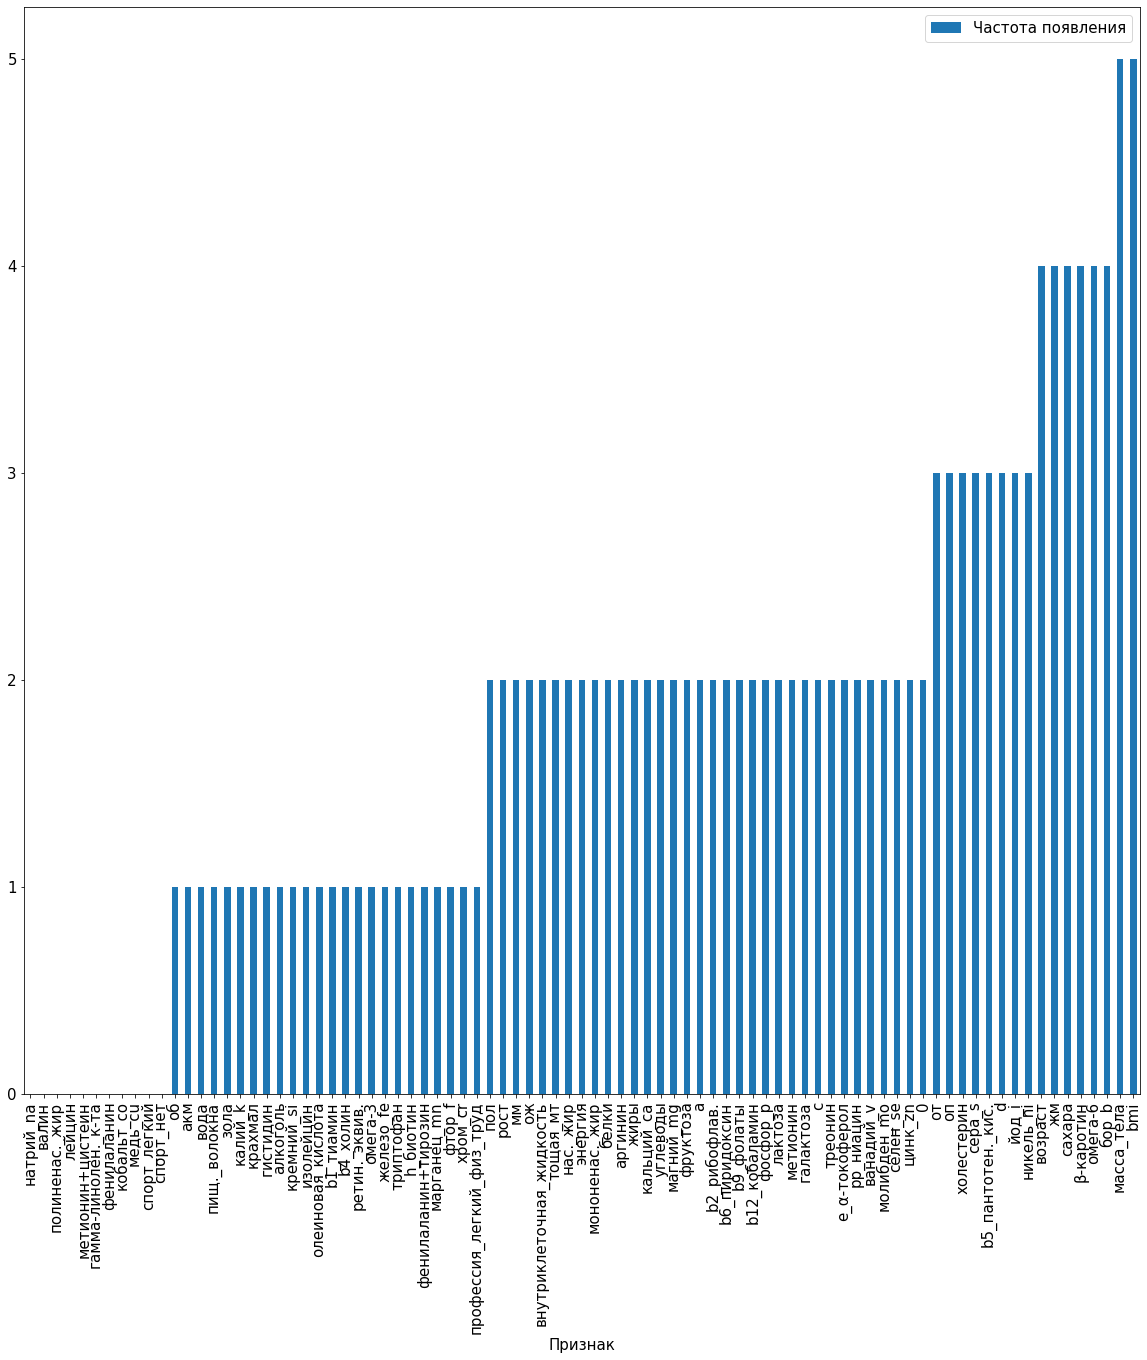

In [61]:
df1=pd.DataFrame(list(sorted_dict_pi.items()),columns=['Признак', 'Частота появления'])
df1.plot(x='Признак', y='Частота появления', kind='bar', rot=90, fontsize=15,figsize=(20, 20))

**Нарисуем гистограмму для SHAP:**

<AxesSubplot:xlabel='Признак'>

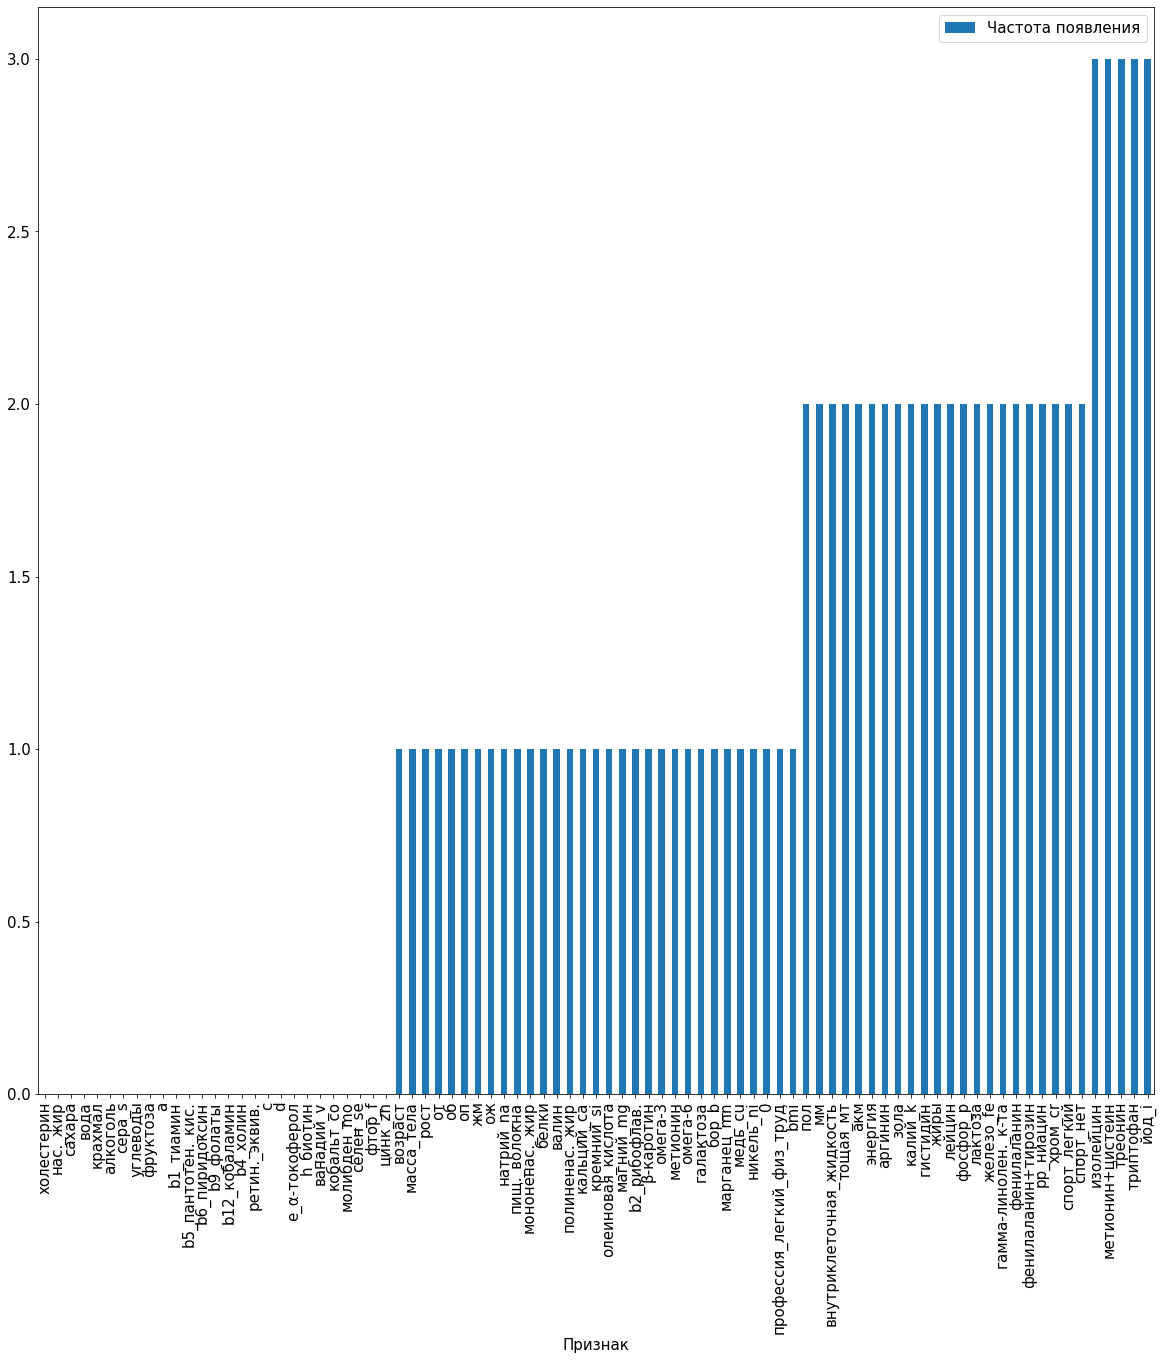

In [62]:
df2=pd.DataFrame(list(sorted_dict_shap.items()),columns=['Признак', 'Частота появления'])
df2.plot(x='Признак', y='Частота появления', kind='bar', rot=90, fontsize=15,figsize=(20, 20))

**Теперь выделим только нутриенты:**

In [63]:
df3=pd.read_csv('.\Новая_база_только_нутриенты.csv')

In [64]:
for name in train_data:
    if name not in df3.columns:
        sorted_dict_shap.pop(name)
        sorted_dict_pi.pop(name)

**Нарисуем гистограмму для PI:**

<AxesSubplot:xlabel='Признак'>

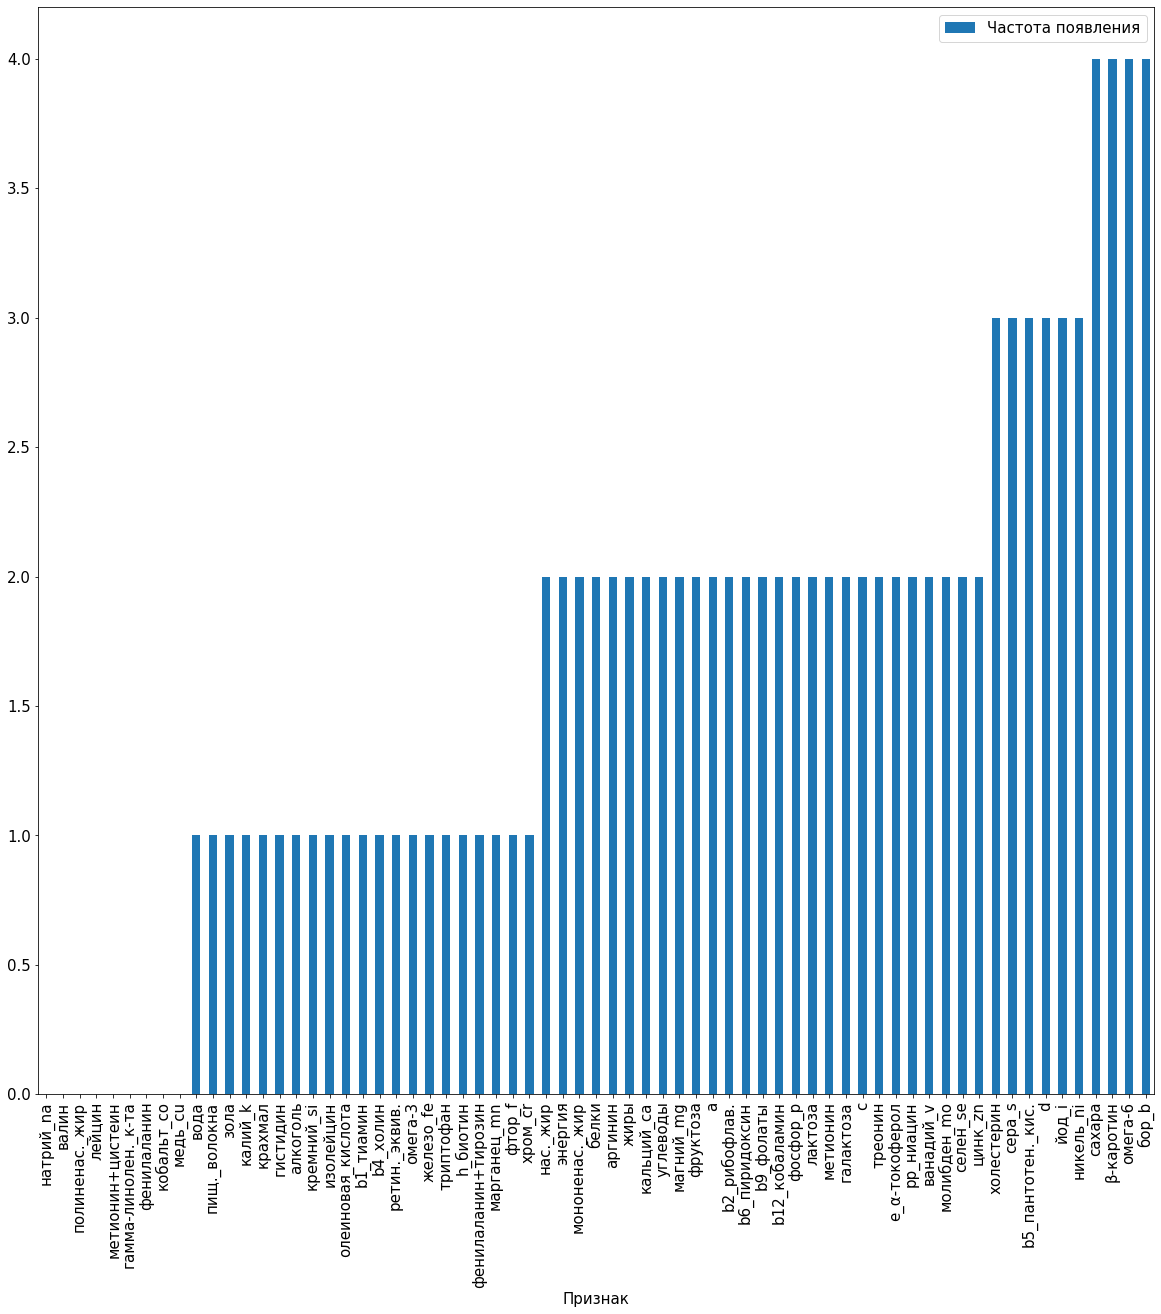

In [65]:
df4=pd.DataFrame(list(sorted_dict_pi.items()),columns=['Признак', 'Частота появления'])
df4.plot(x='Признак', y='Частота появления', kind='bar', rot=90, fontsize=15,figsize=(20, 20))

**Нарисуем гистограмму для SHAP:**

<AxesSubplot:xlabel='Признак'>

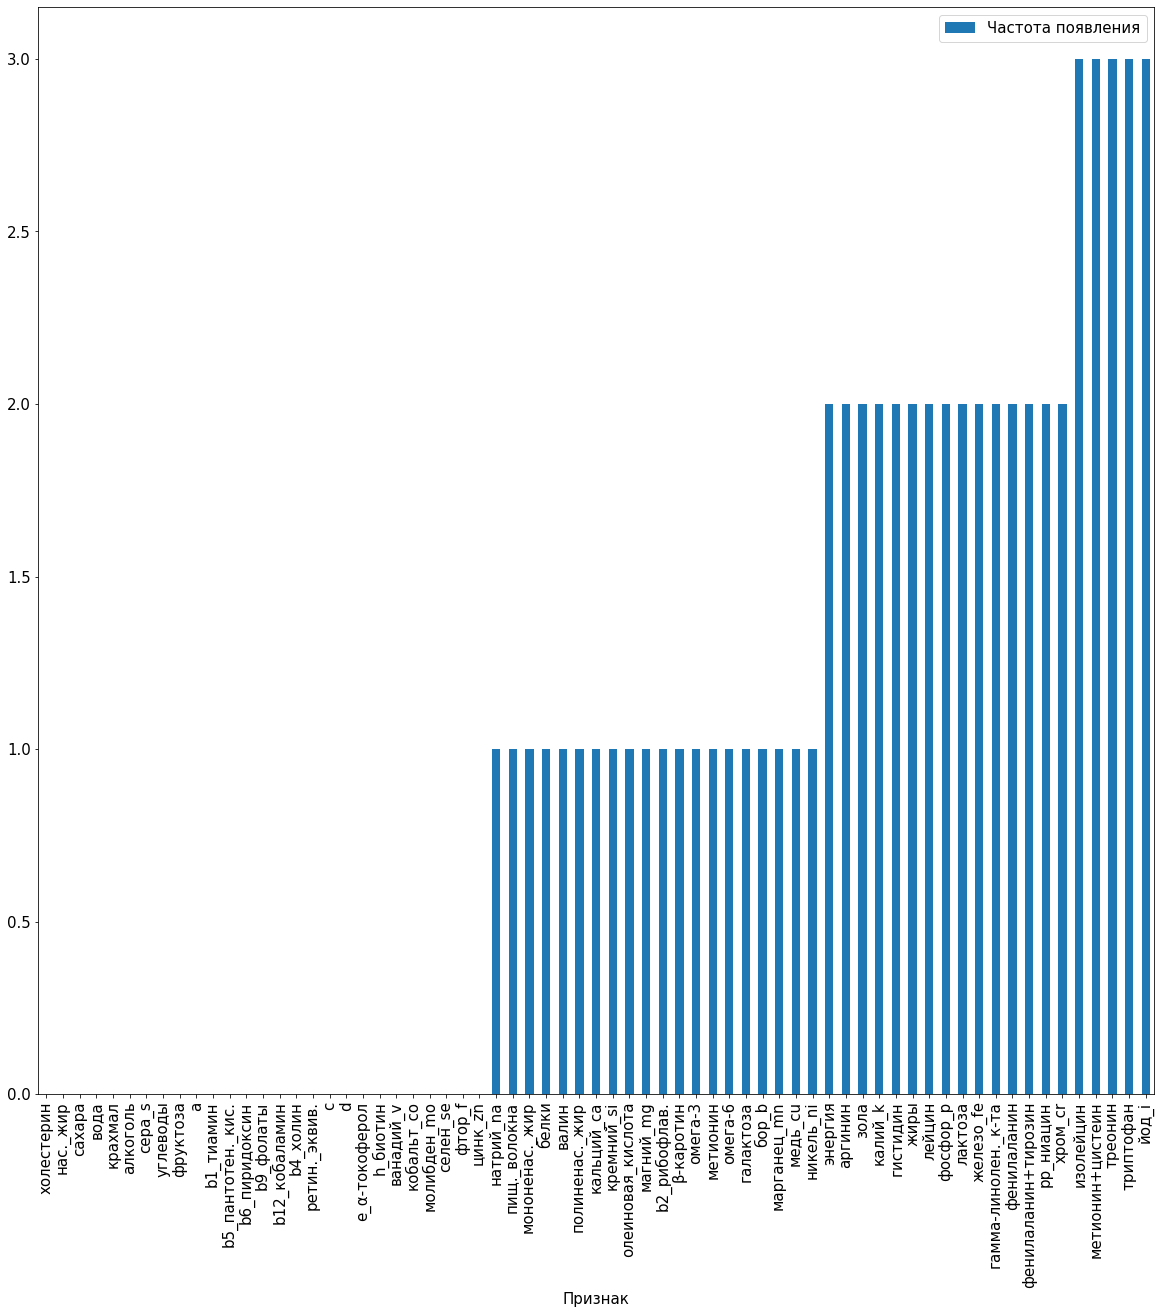

In [66]:
df5=pd.DataFrame(list(sorted_dict_shap.items()),columns=['Признак', 'Частота появления'])
df5.plot(x='Признак', y='Частота появления', kind='bar', rot=90, fontsize=15,figsize=(20, 20))